Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 63

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=63
num_BackTrack_Days=6

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=27 # =(6/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
## DROP_N=550 => 25/07/2021
#
drop_n_dataset_days=550
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
255                                           NaN                 Tunisia   
256                                           NaN                  Turkey   
257                                           NaN           United States   
258                                           NaN                  Uganda   
259                                           NaN                 Ukraine   
260                                           NaN    United Arab Emirates   
261                                      Anguilla          United Kingdom   
262                                       Bermuda          United Kingdom   
263                        British Virgin Islands          United Kingdom   
264                                Cayman Islands          United Kingdom   
265                               Channel Islands          United Kingdom   
266                   Falkland Islands (Malvinas)          United Kingdom   
267                                     Gibraltar          United Kingdom   
268                                      Guernsey          United Kingdom   
269                                   Isle of Man          United Kingdom   
270                                        Jersey          United Kingdom   
271                                    Montserrat          United Kingdom   
272  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
273                      Turks and Caicos Islands          United Kingdom   
274                                           NaN          United Kingdom   
275                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
261                                           NaN                 Tunisia   
262                                           NaN                  Turkey   
263                                           NaN           United States   
264                                           NaN                  Uganda   
265                                           NaN                 Ukraine   
266                                           NaN    United Arab Emirates   
267                                      Anguilla          United Kingdom   
268                                       Bermuda          United Kingdom   
269                        British Virgin Islands          United Kingdom   
270                                Cayman Islands          United Kingdom   
271                               Channel Islands          United Kingdom   
272                   Falkland Islands (Malvinas)          United Kingdom   
273                                     Gibraltar          United Kingdom   
274                                      Guernsey          United Kingdom   
275                                   Isle of Man          United Kingdom   
276                                        Jersey          United Kingdom   
277                                    Montserrat          United Kingdom   
278  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
279                      Turks and Caicos Islands          United Kingdom   
280                                           NaN          United Kingdom   
281                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  5/31/22  6/1/22  6/2/22  6/3/22  \
185        0        0        0        0  ...      299     299     299     299   
186        0        0        0        0  ...      734     735     735     735   
187        0        0        0        0  ...      721     721     722     722   
188        0        0        0        0  ...        0       0       0       0   
189        0        0        0        0  ...      982     982     982     982   
190        0        0        0        0  ...      996     996     996     996   
191        0        0        0        0  ...   324922  324951  324966  324966   
192        0        0        0        0  ...        0       0       0       0   
193        0        0        0        0  ...    11537   11544   11544   11544   
194        0        0        0        0  ...       57      57      57      57   

     6/4/22  6/5/22  6/6/22  6/7/22   Population                 region  
185     299     299     299     299       540,544          Maldives_nan  
186     735     735     735     735    20,250,833              Mali_nan  
187     722     723     723     723       441,543             Malta_nan  
188       0       0       0       0           NaN  Marshall Islands_nan  
189     982     982     982     982     4,649,658        Mauritania_nan  
190     996     996     996     996     1,273,985         Mauritius_nan  
191  325000  325017  325023  325042   128,640,794            Mexico_nan  
192       0       0       0       0           NaN        Micronesia_nan  
193   11544   11544   11544   11544     4,035,942           Moldova_nan  
194      57      57      57      57        39,183            Monaco_nan  

[10 rows x 874 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  1/22/20  1/23/20  \
175            NaN     Micronesia   7.425600  150.55080        0        0   
176            NaN        Moldova  47.411600   28.36990        0        0   
177            NaN         Monaco  43.733300    7.41670        0        0   
178            NaN       Mongolia  46.862500  103.84670        0        0   
179            NaN     Montenegro  42.708678   19.37439        0        0   
180            NaN        Morocco  31.791700   -7.09260        0        0   
181            NaN     Mozambique -18.665700   35.52960        0        0   
182            NaN        Namibia -22.957600   18.49040        0        0   
183            NaN          Nepal  28.166700   84.25000        0        0   
184          Aruba    Netherlands  12.521100  -69.96830        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  5/31/22  6/1/22  6/2/22  6/3/22  \
175        0        0        0        0  ...        0       0       0       0   
176        0        0        0        0  ...        0       0       0       0   
177        0        0        0        0  ...        0       0       0       0   
178        0        0        0        0  ...        0       0       0       0   
179        0        0        0        0  ...        0       0       0       0   
180        0        0        0        0  ...        0       0       0       0   
181        0        0        0        0  ...        0       0       0       0   
182        0        0        0        0  ...        0       0       0       0   
183        0        0        0        0  ...        0       0       0       0   
184        0        0        0        0  ...        0       0       0       0   

     6/4/22  6/5/22  6/6/22  6/7/22   Population              region  
175       0       0       0       0           NaN     Micronesia_nan  
176       0       0       0       0     4,035,942        Moldova_nan  
177       0       0       0       0        39,183         Monaco_nan  
178       0       0       0       0     3,278,290       Mongolia_nan  
179       0       0       0       0       622 500     Montenegro_nan  
180       0       0       0       0    36,817,128        Morocco_nan  
181       0       0       0       0    31,542,919     Mozambique_nan  
182       0       0       0       0     2,540,905        Namibia_nan  
183       0       0       0       0    29,300,000          Nepal_nan  
184       0       0       0       0       116,600  Netherlands_Aruba  

[10 rows x 874 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  5/31/22   6/1/22   6/2/22  \
185        0        0        0        0  ...   179753   179753   179753   
186        0        0        0        0  ...    31097    31102    31103   
187        0        0        0        0  ...    94742    94857    94950   
188        0        0        0        0  ...       17       17       17   
189        0        0        0        0  ...    59141    59154    59168   
190        0        0        0        0  ...   225862   225862   226851   
191        0        0        0        0  ...  5775977  5779027  5782405   
192        0        0        0        0  ...       30       30       30   
193        0        0        0        0  ...   518793   518967   518967   
194        0        0        0        0  ...    12216    12230    12258   

      6/3/22   6/4/22   6/5/22   6/6/22   6/7/22   Population   \
185   179753   179753   179753   179837   179837       540,544   
186    31108    31109    31110    31111    31115    20,250,833   
187    95068    95144    95210    95272    95365       441,543   
188       18       18       18       18       18           NaN   
189    59174    59183    59199    59205    59212     4,649,658   
190   226851   226851   226851   226851   226851     1,273,985   
191  5782405  5789401  5791282  5792317  5797427   128,640,794   
192       30       30       31       34       34           NaN   
193   518967   518967   518967   519001   519001     4,035,942   
194    12284    12300    12306    12306    12186        39,183   

                   region  
185          Maldives_nan  
186              Mali_nan  
187             Malta_nan  
188  Marshall Islands_nan  
189        Mauritania_nan  
190         Mauritius_nan  
191            Mexico_nan  
192        Micronesia_nan  
193           Moldova_nan  
194            Monaco_nan  

[10 rows x 874 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Philippines  12.879721  121.774017   
221            NaN                            Poland  51.919400   19.145100   
222            NaN                          Portugal  39.399900   -8.224500   
223            NaN                             Qatar  25.354800   51.183900   
224            NaN                           Romania  45.943200   24.966800   
225            NaN                            Russia  61.524010  105.318756   
226            NaN                            Rwanda  -1.940300   29.873900   
227            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
228            NaN                       Saint Lucia  13.909400  -60.978900   
229            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...   5/31/22  \
220        0        0        0        0        0        0  ...   3690581   
221        0        0        0        0        0        0  ...   6007584   
222        0        0        0        0        0        0  ...   4683018   
223        0        0        0        0        0        0  ...    368788   
224        0        0        0        0        0        0  ...   2909195   
225        0        0        0        0        0        0  ...  18063880   
226        0        0        0        0        0        0  ...    130057   
227        0        0        0        0        0        0  ...      5729   
228        0        0        0        0        0        0  ...     25593   
229        0        0        0        0        0        0  ...      8670   

       6/1/22    6/2/22    6/3/22    6/4/22    6/5/22    6/6/22    6/7/22  \
220   3690707   3690889   3691114   3691327   3691546   3691724   3691892   
221   6007840   6008059   6008295   6008550   6008612   6008665   6009003   
222   4717243   4749137   4775529   4775529   4775529   4775529   4846230   
223    369049    369305    369526    369526    369929    370235    370551   
224   2909495   2909677   2910081   2910392   2910553   2910766   2911170   
225  18067977  18072173  18076286  18080277  18083984  18087265  18090459   
226    130061    130116    130141    130159    130180    130197    130215   
227      5746      5757      5782      5798      5805      5809      5811   
228     25777     25877     25999     26092     26092     26206     26234   
229      8717      8741      8762      8762      8762      8762      8807   

      Population                                 region  
220   104,900,000                       Philippines_nan  
221    37,980,000                            Poland_nan  
222    10,290,000                          Portugal_nan  
223     2,870,256                             Qatar_nan  
224    19,530,000                           Romania_nan  
225   144,500,000                            Russia_nan  
226    12,952,218                            Rwanda_nan  
227        53,673             Saint Kitts and Nevis_nan  
228       184,106                       Saint Lucia_nan  
229       110,940  Saint Vincent and the Grenadines_nan  

[10 rows x 874 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

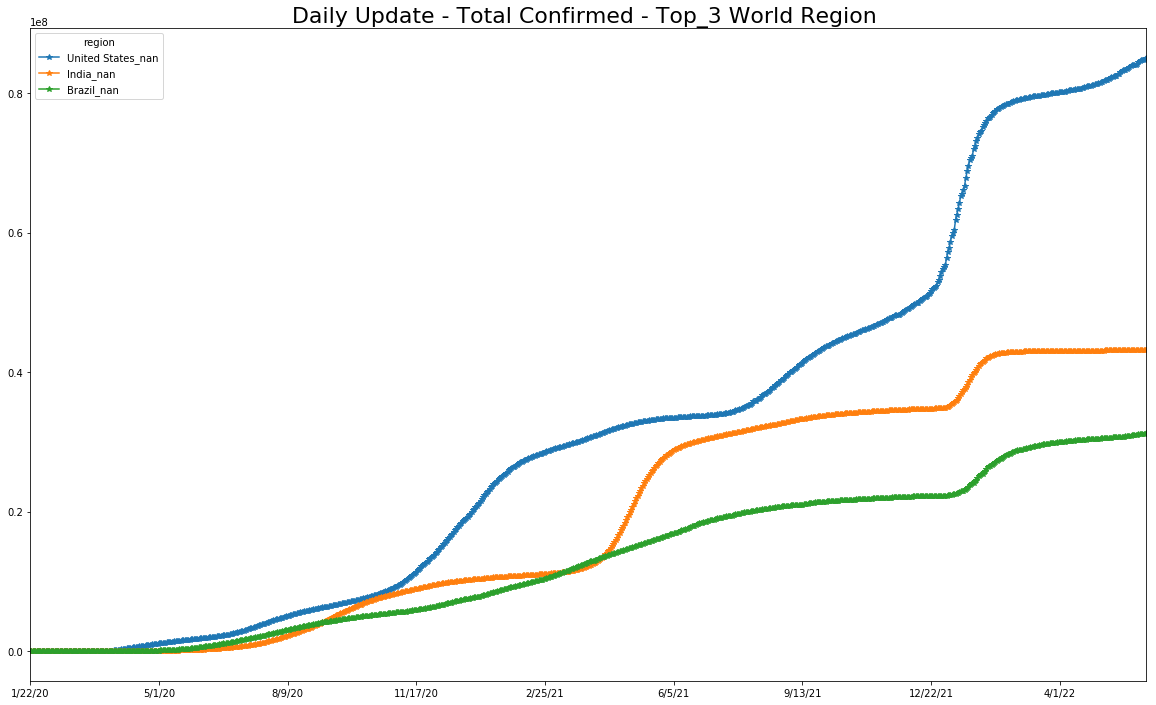

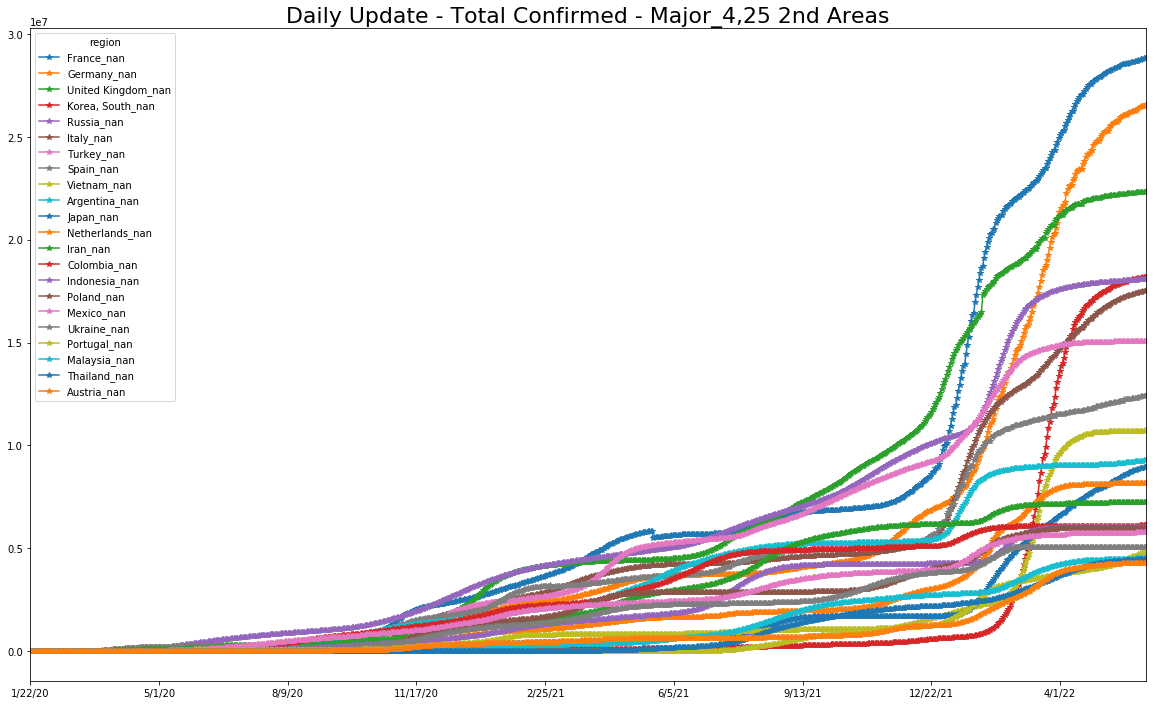

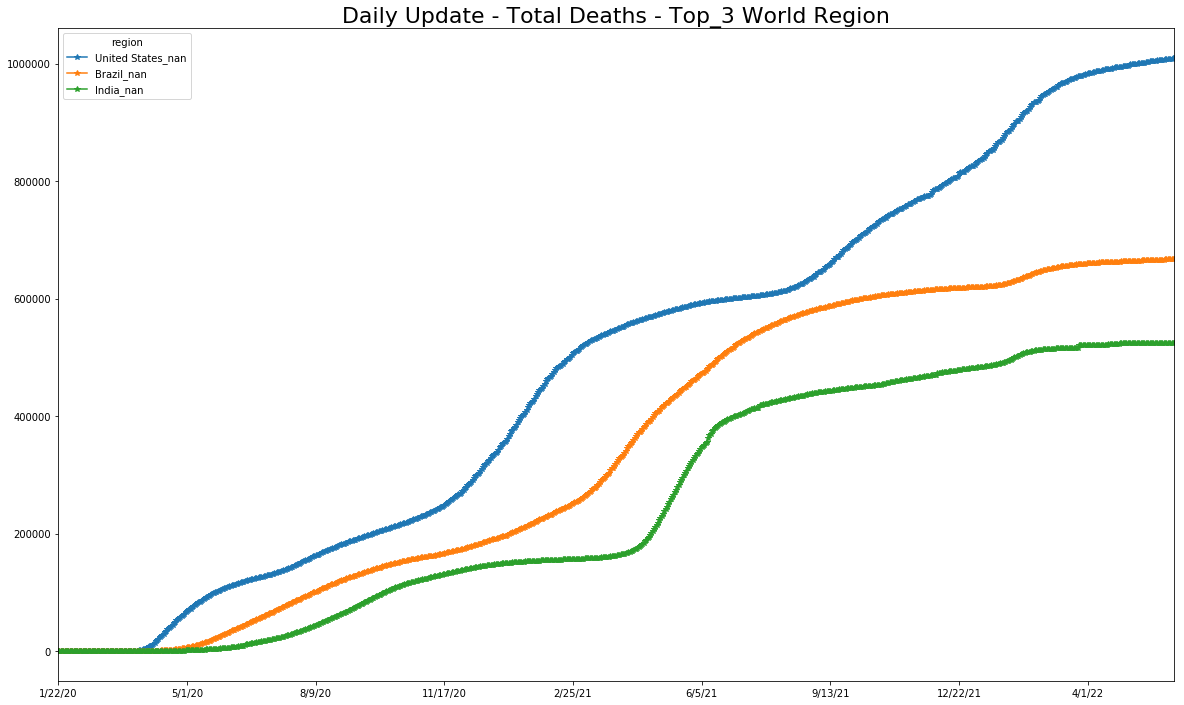

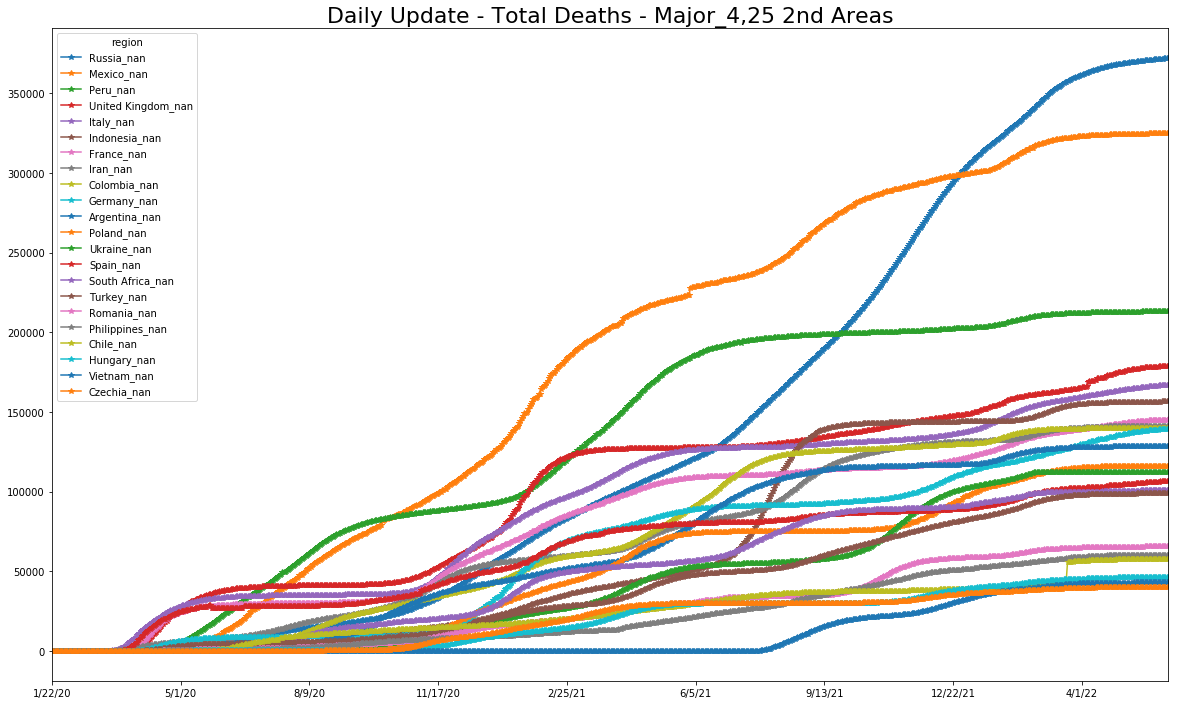

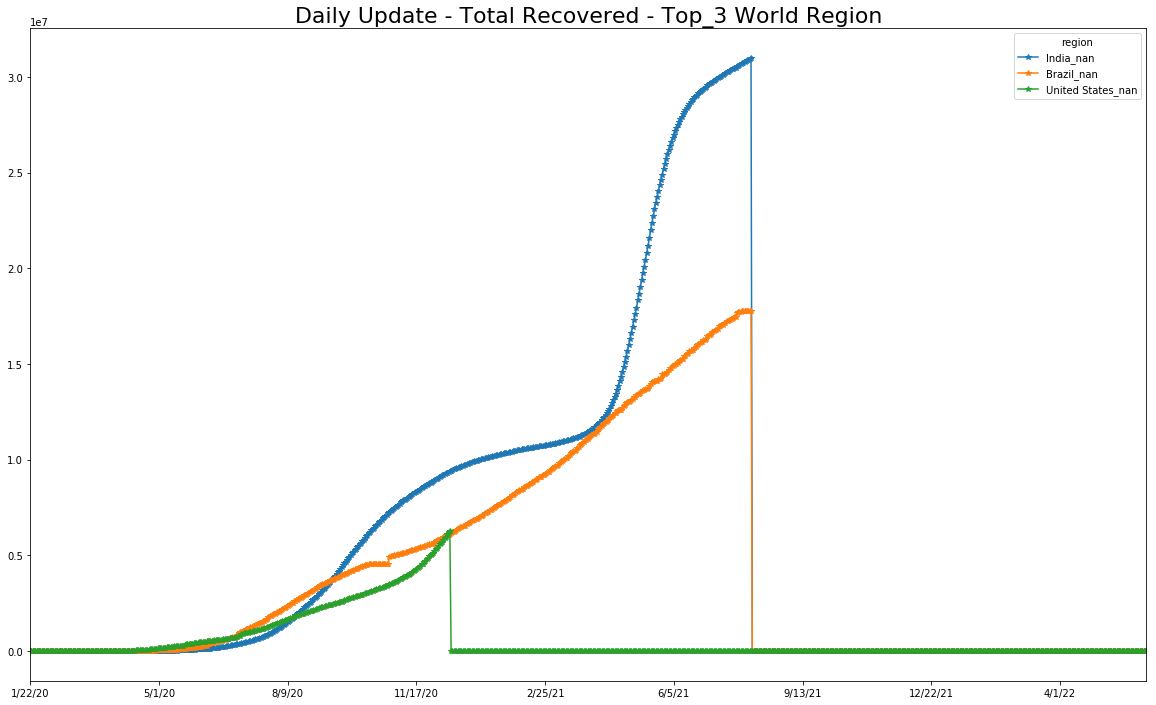

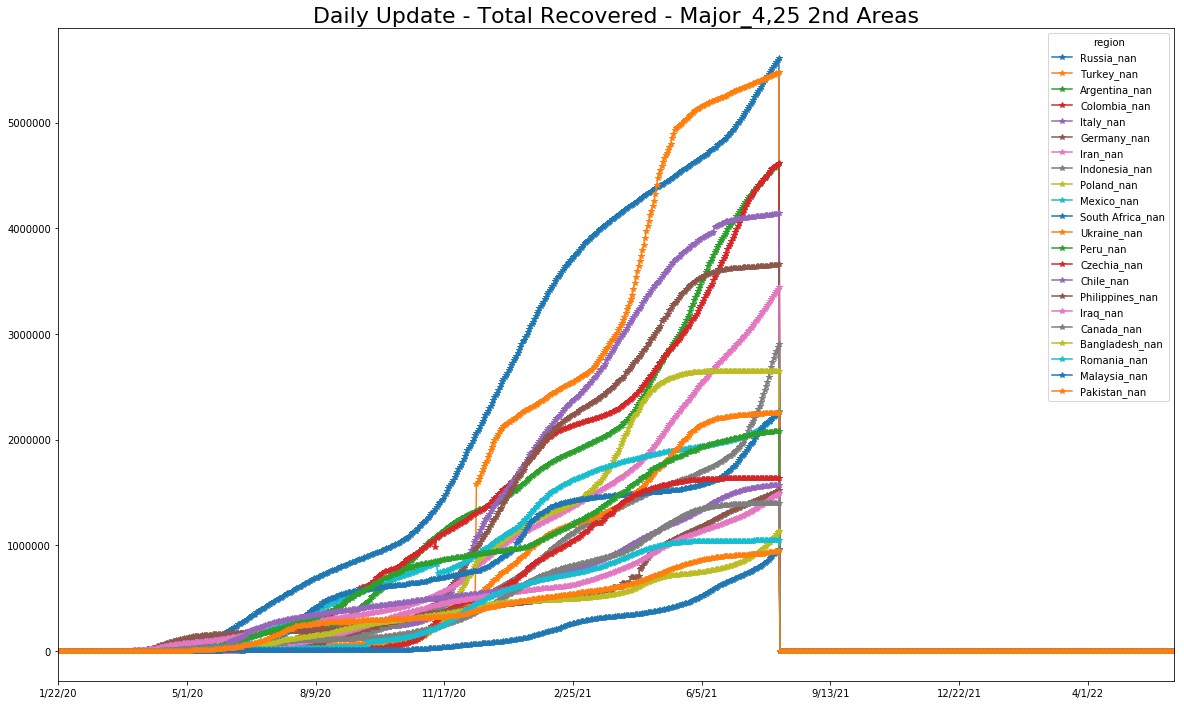

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/06/08


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/25/21           143871       132875       162155        14498       41780   
7/26/21           144285       132891       163660        14577       41879   
7/27/21           145008       132922       165204        14586       42110   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/25/21               0                     1280        4846615       228798   
7/26/21               0                     1280        4859170       228910   
7/27/21               0                     1288        4875927       229090   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
7/25/21                                     124  ...       380431   
7/26/21                                     124  ...       380584   
7/27/21                                     124  ...       380793   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
7/25/21          124290            4         299822       101173   
7/26/21          124995            4         300919       106347   
7/27/21          125784            4         301979       117121   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
7/25/21                  316088                         0       7012   
7/26/21                  316088                         0       7012   
7/27/21                  316189                         0       7022   

region   Zambia_nan  Zimbabwe_nan  
7/25/21      192071         97894  
7/26/21      192316         99944  
7/27/21      192956        101711  

[3 rows x 285 columns]

In [25]:
ts[-4:]

region  Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
6/4/22           180615       276342       265889        43067       99761   
6/5/22           180615       276401       265897        43067       99761   
6/6/22           180688       276415       265900        43067       99761   
6/7/22           180741       276468       265904        43067       99761   

region  Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
6/4/22              11                     8378        9230573       422963   
6/5/22              11                     8378        9276618       422963   
6/6/22              11                     8378        9276618       423006   
6/7/22              11                     8378        9276618       423006   

region  Australia_Australian Capital Territory  ...  Uruguay_nan  \
6/4/22                                  134286  ...       925777   
6/5/22                                  134286  ...       925777   
6/6/22                                  136860  ...       925777   
6/7/22                                  137664  ...       934961   

region  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
6/4/22          239092         9445         523833     10724554   
6/5/22          239092         9445         523901     10725239   
6/6/22          239135        10061         523937     10726045   
6/7/22          239141        10239         523969     10727005   

region  West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
6/4/22                  657705                       535      11822   
6/5/22                  657705                       535      11822   
6/6/22                  657705                       535      11822   
6/7/22                  657879                       535      11822   

region  Zambia_nan  Zimbabwe_nan  
6/4/22      322207        253236  
6/5/22      322207        253338  
6/6/22      322207        253508  
6/7/22      322562        253637  

[4 rows x 285 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-07-26  Afghanistan_nan     144285             0             0   
2     2021-07-27  Afghanistan_nan     145008           414             0   
3     2021-07-28  Afghanistan_nan     145552           723             0   
4     2021-07-29  Afghanistan_nan     145996           544          1681   
5     2021-07-30  Afghanistan_nan     146523           444          1711   
6     2021-07-31  Afghanistan_nan     147154           527          1515   
7     2021-08-01  Afghanistan_nan     147501           631          1602   
8     2021-08-02  Afghanistan_nan     147985           347          1505   
9     2021-08-03  Afghanistan_nan     148572           484          1462   
10    2021-08-04  Afghanistan_nan     148933           587          1418   
11    2021-08-05  Afghanistan_nan     149361           361          1432   
12    2021-08-06  Afghanistan_nan     149810           428          1376   
13    2021-08-07  Afghanistan_nan     150240           449          1238   
14    2021-08-08  Afghanistan_nan     150458           430          1307   
15    2021-08-09  Afghanistan_nan     150778           218          1097   
16    2021-08-10  Afghanistan_nan     151013           320           968   
17    2021-08-11  Afghanistan_nan     151291           235           773   
18    2021-08-12  Afghanistan_nan     151563           278           833   
19    2021-08-13  Afghanistan_nan     151770           272           785   
20    2021-08-14  Afghanistan_nan     151941           207           757   
21    2021-08-15  Afghanistan_nan     152033           171           650   
22    2021-08-16  Afghanistan_nan     152142            92           470   
23    2021-08-17  Afghanistan_nan     152243           109           372   
24    2021-08-18  Afghanistan_nan     152363           101           302   
25    2021-08-19  Afghanistan_nan     152411           120           330   
26    2021-08-20  Afghanistan_nan     152448            48           269   
27    2021-08-21  Afghanistan_nan     152497            37           205   
28    2021-08-22  Afghanistan_nan     152511            49           134   
29    2021-08-23  Afghanistan_nan     152583            14           100   
30    2021-08-24  Afghanistan_nan     152660            72           135   
...          ...              ...        ...           ...           ...   
92799 2022-05-10     Zimbabwe_nan     248642           184           322   
92800 2022-05-11     Zimbabwe_nan     248642           106           428   
92801 2022-05-12     Zimbabwe_nan     248943             0           290   
92802 2022-05-13     Zimbabwe_nan     249131           301           407   
92803 2022-05-14     Zimbabwe_nan     249206           188           489   
92804 2022-05-15     Zimbabwe_nan     249206            75           564   
92805 2022-05-16     Zimbabwe_nan     249431             0           263   
92806 2022-05-17     Zimbabwe_nan     249748           225           300   
92807 2022-05-18     Zimbabwe_nan     250007           317           542   
92808 2022-05-19     Zimbabwe_nan     250206           259           801   
92809 2022-05-20     Zimbabwe_nan     250469           199           775   
92810 2022-05-21     Zimbabwe_nan     250469           263           721   
92811 2022-05-22     Zimbabwe_nan     250642             0           462   
92812 2022-05-23     Zimbabwe_nan     250702           173           436   
92813 2022-05-24     Zimbabwe_nan     250929            60           233   
92814 2022-05-25     Zimbabwe_nan     251228           227           460   
92815 2022-05-26     Zimbabwe_nan     251646           299           586   
92816 2022-05-27     Zimbabwe_nan     251959           418           944   
92817 2022-05-28     Zimbabwe_nan     251959           313          1030   
92818 2022-05-29     Zimbabwe_nan     252092             0           731   
92819 2022-05-30     Zimbabwe_nan     252092           133  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
92828 2022-06-08  Zimbabwe_nan          0           129           401   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
92828          1239          100.05089         100.158354         100.490895   

       last_day  kalman_prediction  population  infected_rate  min  max  
92828    253637           253819.0    14862924       0.000171  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
92828 2022-06-08  Zimbabwe_nan          0           129           401   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
92828          1239          100.05089         100.158354         100.490895   

       last_day  kalman_prediction  population  infected_rate  min  max  
92828    253637           253819.0    14862924       0.000171  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
90912  2022-06-06  Zimbabwe_nan     253508           102           287   
90913  2022-06-07  Zimbabwe_nan     253637           170           272   
90914  2022-06-08  Zimbabwe_nan          0           129           401   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
90912          1246         100.040283         100.113420         100.494268   
90913          1416         100.067108         100.107414         100.561704   
90914          1239         100.050890         100.158354         100.490895   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
90912               253338  ...    14862924       0.000170  NaN  NaN   
90913               253508  ...    14862924       0.000171  NaN  NaN   
90914               253637  ...    14862924       0.000171  NaN  NaN   

       population_percentage : infected_rate confirmed  \
90912                                         0.017045   
90913                                         0.017056   
90914                                         0.017065   

       population_percentage : factor 9/10 infected_rate confirmed  \
90912                                           0.153405             
90913                                           0.153508             
90914                                           0.153586             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
90912                   281.0                          18.906105   
90913                   210.0                          14.129118   
90914                   182.0                          12.245235   

       delta : roling 7day AVG  \
90912               178.000000   
90913               202.285714   
90914               177.000000   

       delta : aprox 14-day case notification rate per 100k hab  
90912                                          16.766553         
90913                                          19.054124         
90914                                          16.672359         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse           mae
274  United States_nan  2.288783e+13  4.784122e+06  367739.54717


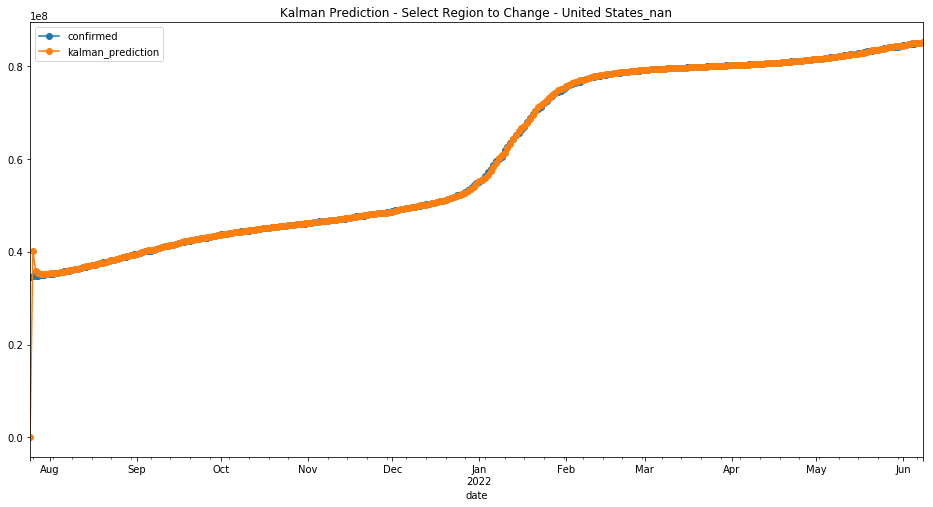

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
219  Russia_nan  1.032881e+12  1.016307e+06  70233.990566


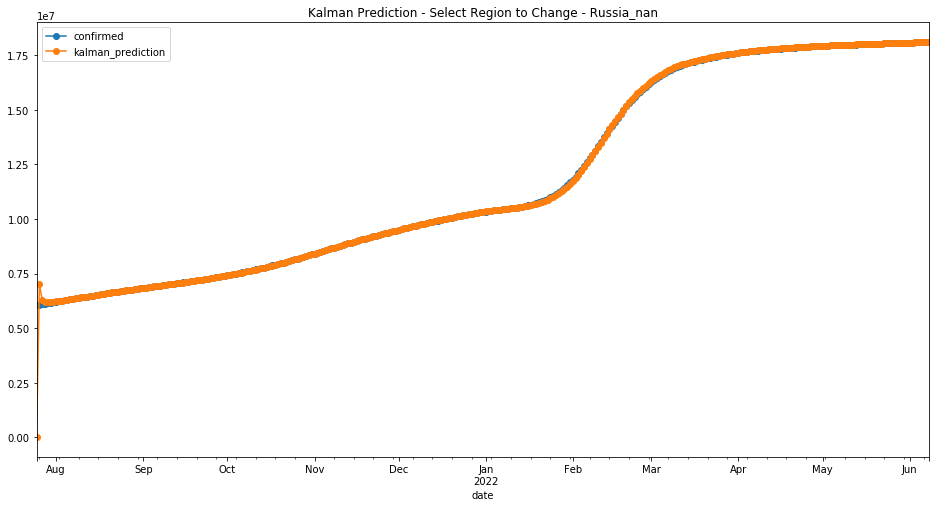

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  3.108819e+12  1.763184e+06  132377.176101


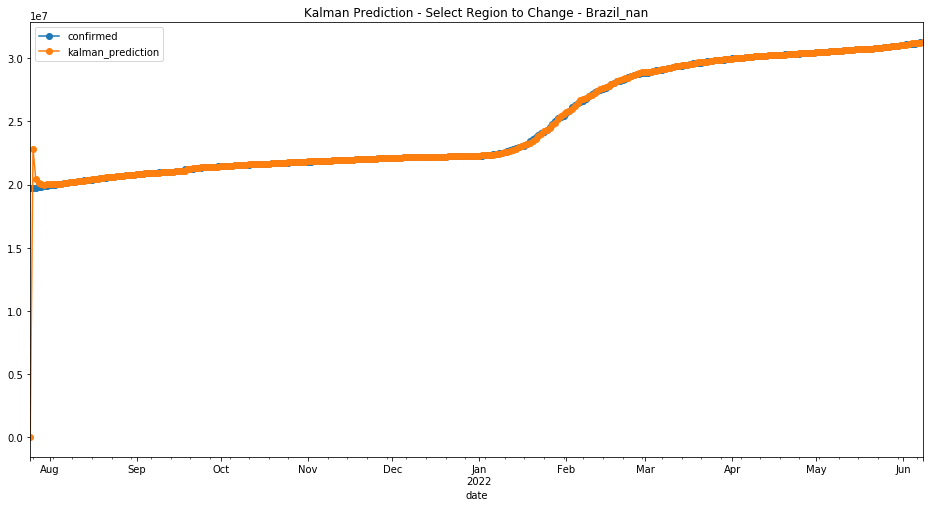

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse            mae
273  United Kingdom_nan  1.576905e+12  1.255749e+06  100585.726415


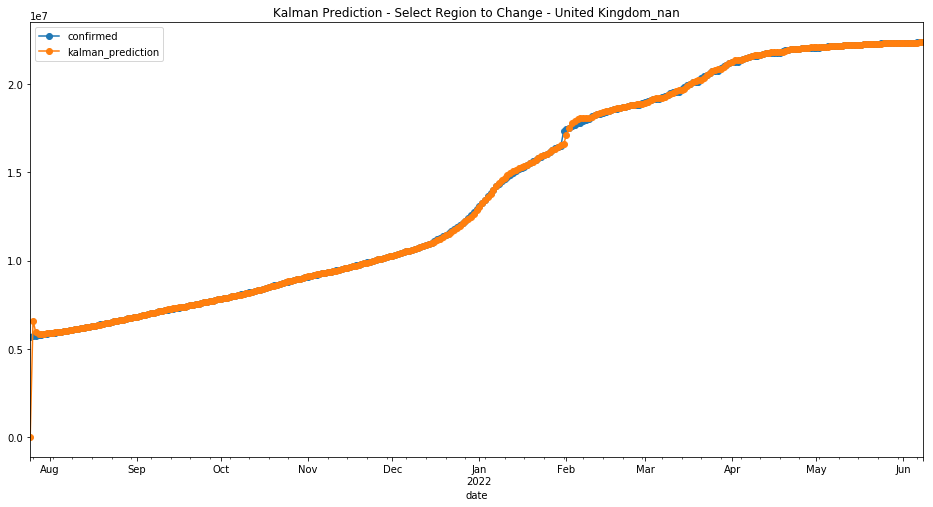

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpkiisg0wv
  JVM stdout: /tmp/tmpkiisg0wv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpkiisg0wv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 7 months and 12 days !!!
H2O cluster name:           H2O_from_python_unknownUser_2nyzl3
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-05-12
last_train_date= 2022-06-07
first_bootstrap_date= 2022-05-30
boost_bootstrap_date= 2022-06-04
first_test_date= 2022-05-29
last_test_date= 2022-06-08
first_valid_date= 2022-06-06


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   181513.0     180259 2022-05-30  Afghanistan_nan
1   181598.0     180347 2022-05-31  Afghanistan_nan
2   181686.0     180419 2022-06-01  Afghanistan_nan
3   181763.0     180520 2022-06-02  Afghanistan_nan
4   181857.0     180584 2022-06-03  Afghanistan_nan
5   181936.0     180615 2022-06-04  Afghanistan_nan
6   181974.0     180615 2022-06-05  Afghanistan_nan
7   181978.0     180688 2022-06-06  Afghanistan_nan
8   182031.0     180741 2022-06-07  Afghanistan_nan
9   182071.0          0 2022-06-08  Afghanistan_nan
10  276927.0     276101 2022-05-30      Albania_nan
11  276926.0     276101 2022-05-31      Albania_nan
12  276924.0     276221 2022-06-01      Albania_nan
13  277035.0     276221 2022-06-02      Albania_nan
14  277025.0     276310 2022-06-03      Albania_nan
15  277126.0     276342 2022-06-04      Albania_nan
16  277158.0     276401 2022-06-05      Albania_nan
17  277226.0     276415 2022-06-06      Albania_nan
18  277242.0     276468 2022-06-07      Albania_nan
19  277298.0          0 2022-06-08      Albania_nan
20  267139.0     265877 2022-05-30      Algeria_nan
21  267142.0     265884 2022-05-31      Algeria_nan
22  267148.0     265887 2022-06-01      Algeria_nan
23  267152.0     265889 2022-06-02      Algeria_nan
24  267154.0     265889 2022-06-03      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  4295903.0    4295818 2022-06-04     Austria_nan
176  4295339.0    4295818 2022-06-05     Austria_nan
177  4295565.0    4304326 2022-06-06     Austria_nan
178  4305907.0    4306509 2022-06-07     Austria_nan
179  4305767.0          0 2022-06-08     Austria_nan
180   793543.0     792759 2022-05-30  Azerbaijan_nan
181   793548.0     792767 2022-05-31  Azerbaijan_nan
182   793557.0     792778 2022-06-01  Azerbaijan_nan
183   793566.0     792785 2022-06-02  Azerbaijan_nan
184   793572.0     792785 2022-06-03  Azerbaijan_nan
185   793573.0     792785 2022-06-04  Azerbaijan_nan
186   793574.0     792785 2022-06-05  Azerbaijan_nan
187   793573.0     792785 2022-06-06  Azerbaijan_nan
188   793571.0     792785 2022-06-07  Azerbaijan_nan
189   793570.0          0 2022-06-08  Azerbaijan_nan
190    35450.0      34713 2022-05-30     Bahamas_nan
191    35596.0      34759 2022-05-31     Bahamas_nan
192    35640.0      34861 2022-06-01     Bahamas_nan
193    35632.0      34861 2022-06-02     Bahamas_nan
194    35822.0      34931 2022-06-03     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220   80246.0      80324 2022-05-30  Barbados_nan
221   80386.0      80654 2022-05-31  Barbados_nan
222   80492.0      80846 2022-06-01  Barbados_nan
223   80734.0      81028 2022-06-02  Barbados_nan
224   80941.0      81174 2022-06-03  Barbados_nan
225   81113.0      81319 2022-06-04  Barbados_nan
226   81255.0      81427 2022-06-05  Barbados_nan
227   81389.0      81518 2022-06-06  Barbados_nan
228   81477.0      81622 2022-06-07  Barbados_nan
229   81563.0          0 2022-06-08  Barbados_nan
230  983477.0     982867 2022-05-30   Belarus_nan
231  983477.0     982867 2022-05-31   Belarus_nan
232  983477.0     982867 2022-06-01   Belarus_nan
233  983477.0     982867 2022-06-02   Belarus_nan
234  983477.0     982867 2022-06-03   Belarus_nan
235  983477.0     982867 2022-06-04   Belarus_nan
236  983477.0     982867 2022-06-05   Belarus_nan
237  983477.0     982867 2022-06-06   Belarus_nan
238  983477.0     982867 2022-06-07   Belarus_nan
239  983477.0          0 2022-06-08   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  106959284246.54181
# MSE on the validation data =  123827205911792.44
# R^2 on the training data =  0.999333494461211
# R^2 on the validation data =  0.37421565459370987


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1654682109907_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 106959284246.54181
RMSE: 327046.3029091474
MAE: 24585.60236940487
RMSLE: 0.3435360284094
Mean Residual Deviance: 106959284246.54181

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 123827205911792.44
RMSE: 11127767.337242113
MAE: 3607400.557163507
RMSLE: 8.66384220276329
Mean Residual Deviance: 123827205911792.44
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-06-08 09:55:19  0.068 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-06-08 09:55:19  0.527 sec   1.0                422792.88363455527  55592.55770093043   178753822452.02258   11123026.938514214  3601697.1776815876  123721728274912.9
     2022-06-08 09:55:19  0.679 sec   2.0                671327.5939814884   64373.56806870469   450680738440.9741    11174414.111864926  3656963.436866554   124867530743446.02
     2022-06-08 09:55:19  0.804 sec   3.0                526345.7253653167   55923.58896225417   277039822610.3414    11155687.537664736  3636640.2323104353  124449364438008.31
     2022-06-08 09:55:19  0.930 sec   4.0                510378.59979428595  55276.12425996341   260486315127.9759    11151670.766748928  3630875.682495719   124359760889962.6
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-06-08 09:55:35  16.171 sec  240.0              340999.19525275053  26658.39522402477   116280451163.02348   11126227.64077974   3607259.2087370898  123792941514451.06
     2022-06-08 09:55:39  20.209 sec  313.0              339230.6261976896   26156.722653921144  115077417750.47664   11125562.429736244  3608222.2844203534  123778139377958.62
     2022-06-08 09:55:43  24.253 sec  385.0              338322.02380600513  25699.62989954743   114461791792.19112   11125339.252583072  3606527.8122249856  123773173485065.66
     2022-06-08 09:55:47  28.262 sec  455.0              332509.84454075916  25095.146536974615  110562796716.51982   11127050.13152677   3607248.486309667   123811244629509.9
     2022-06-08 09:55:50  31.049 sec  500.0              327046.3029091474   24585.60236940487   106959284246.54181   11127767.337242113  3607400.557163507   123827205911792.44


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  3.0468e+20             1                    0.373654
last_day           2.58982e+20            0.850013             0.31761
region             1.47144e+20            0.482946             0.180454
7_day_change       3.58993e+19            0.117827             0.0440263
3_day_change       2.65276e+19            0.0870671            0.0325329
infected_rate      1.81861e+19            0.0596893            0.0223031
1_day_change       1.24666e+19            0.040917             0.0152888
7_day_change_rate  5.98106e+18            0.0196307            0.00733506
3_day_change_rate  3.39141e+18            0.0111311            0.00415916
1_day_change_rate  2.14958e+18            0.00705523           0.00263621

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         3.046796e+20           1.000000    0.373654
1           last_day         2.589817e+20           0.850013    0.317610
2             region         1.471437e+20           0.482946    0.180454
3       7_day_change         3.589933e+19           0.117827    0.044026
4       3_day_change         2.652758e+19           0.087067    0.032533
5      infected_rate         1.818610e+19           0.059689    0.022303
6       1_day_change         1.246658e+19           0.040917    0.015289
7  7_day_change_rate         5.981060e+18           0.019631    0.007335
8  3_day_change_rate         3.391408e+18           0.011131    0.004159
9  1_day_change_rate         2.149584e+18           0.007055    0.002636

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


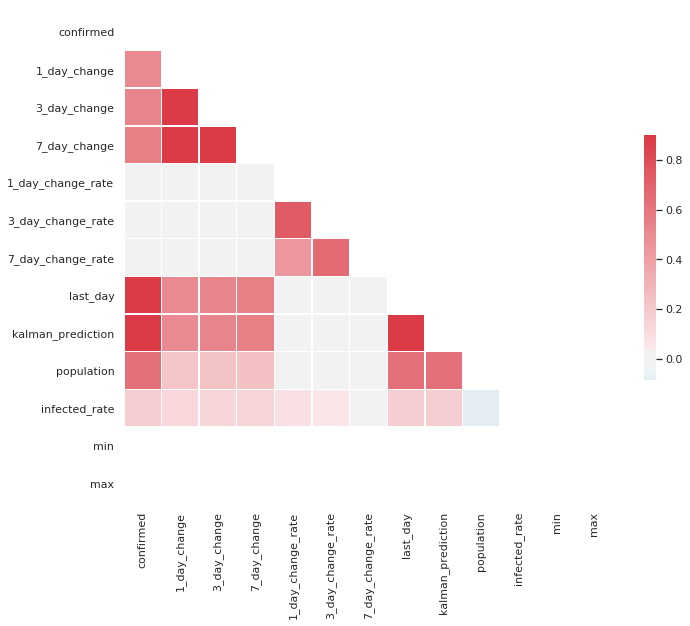

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.510264
3_day_change         0.540690
7_day_change         0.558345
1_day_change_rate    0.020852
3_day_change_rate    0.011511
7_day_change_rate    0.000069
last_day             0.995686
kalman_prediction    0.996308
population           0.624524
infected_rate        0.178969
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


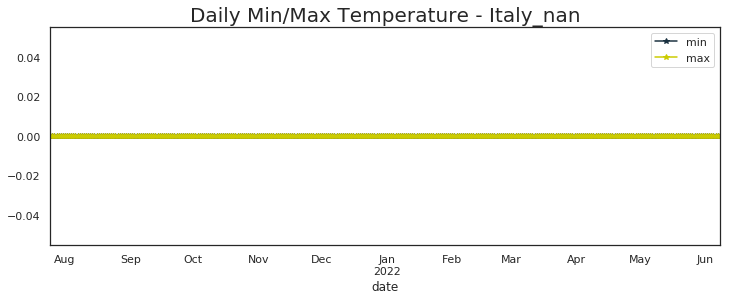

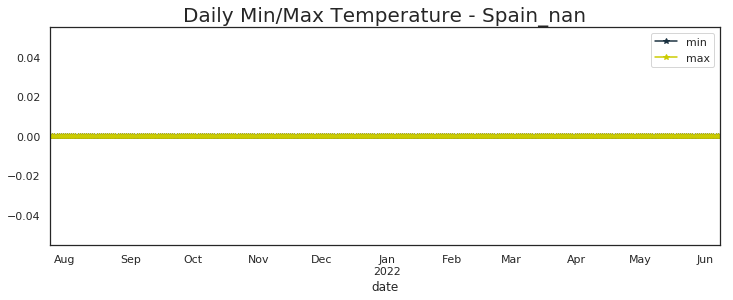

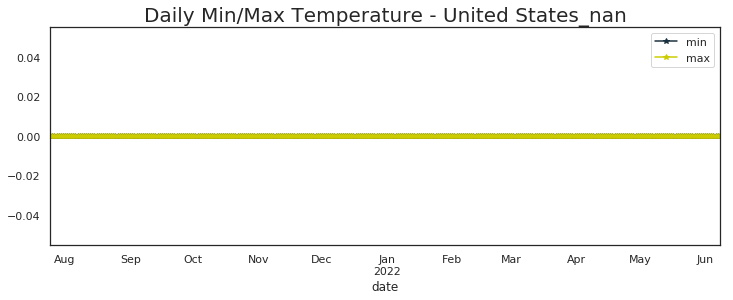

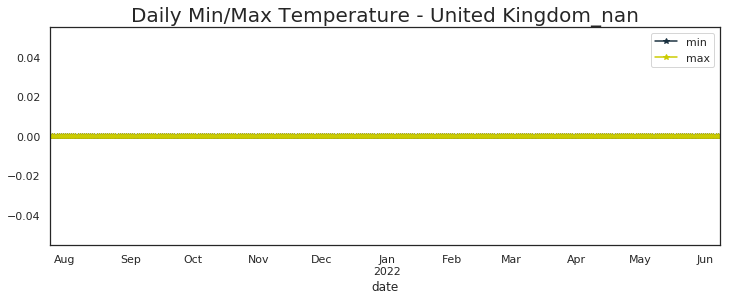

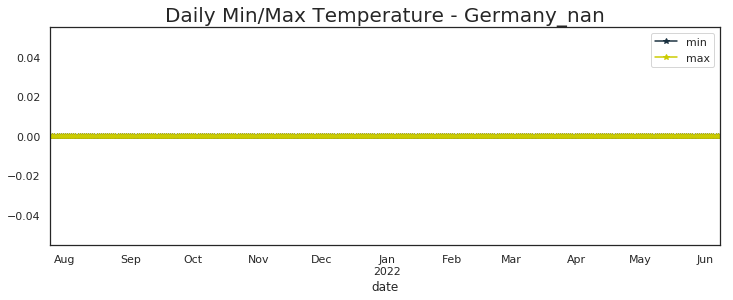

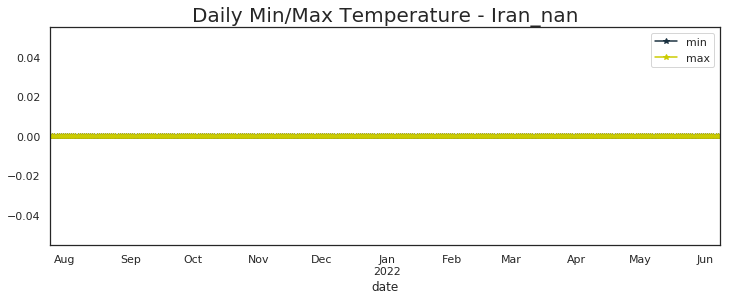

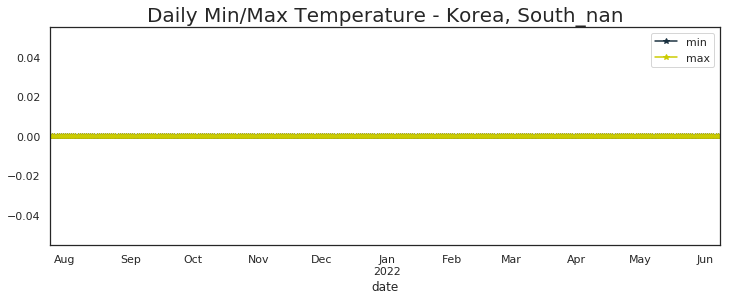

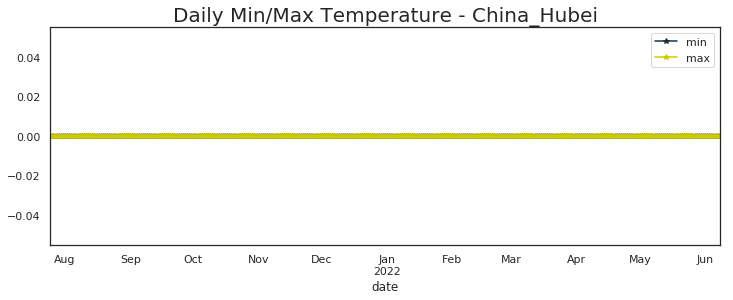

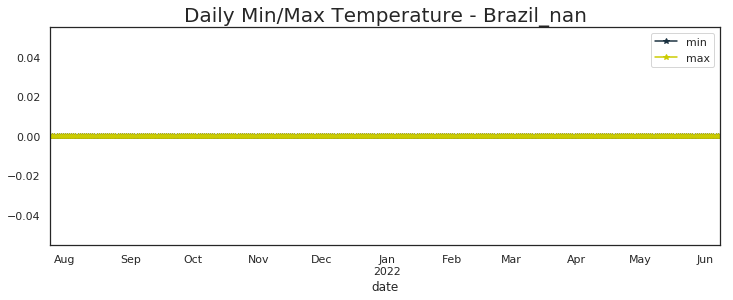

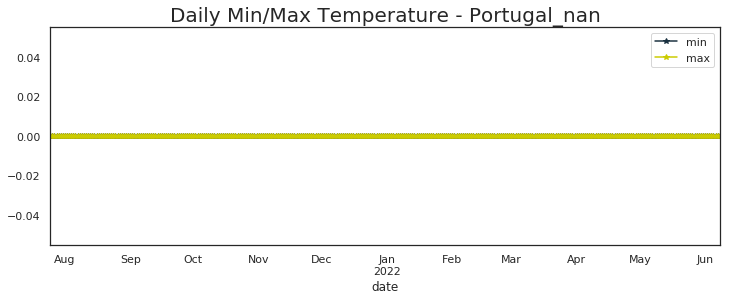

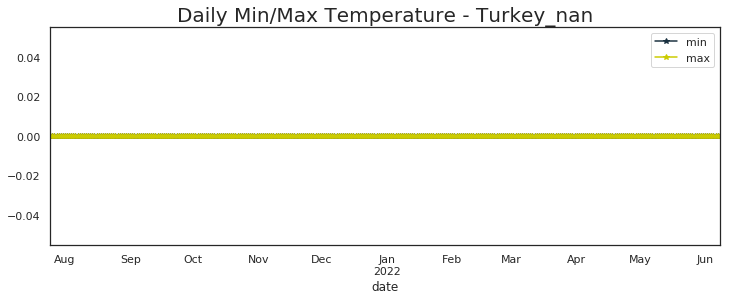

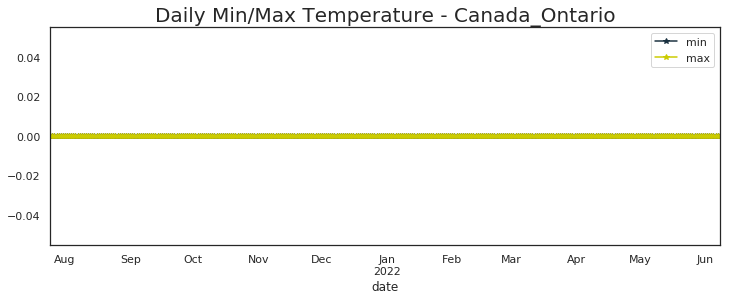

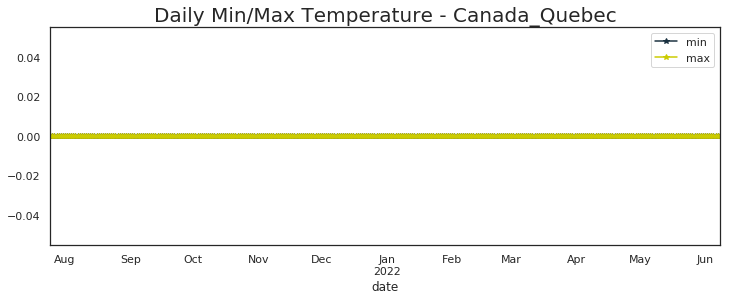

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min  max
region                               
United States_nan            0.0  0.0
India_nan                    0.0  0.0
Brazil_nan                   0.0  0.0
France_nan                   0.0  0.0
Germany_nan                  0.0  0.0
United Kingdom_nan           0.0  0.0
Korea, South_nan             0.0  0.0
Russia_nan                   0.0  0.0
Italy_nan                    0.0  0.0
Turkey_nan                   0.0  0.0
Spain_nan                    0.0  0.0
Vietnam_nan                  0.0  0.0
Argentina_nan                0.0  0.0
Japan_nan                    0.0  0.0
Netherlands_nan              0.0  0.0
Iran_nan                     0.0  0.0
Colombia_nan                 0.0  0.0
Indonesia_nan                0.0  0.0
Poland_nan                   0.0  0.0
Mexico_nan                   0.0  0.0
Ukraine_nan                  0.0  0.0
Portugal_nan                 0.0  0.0
Malaysia_nan                 0.0  0.0
Thailand_nan  

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

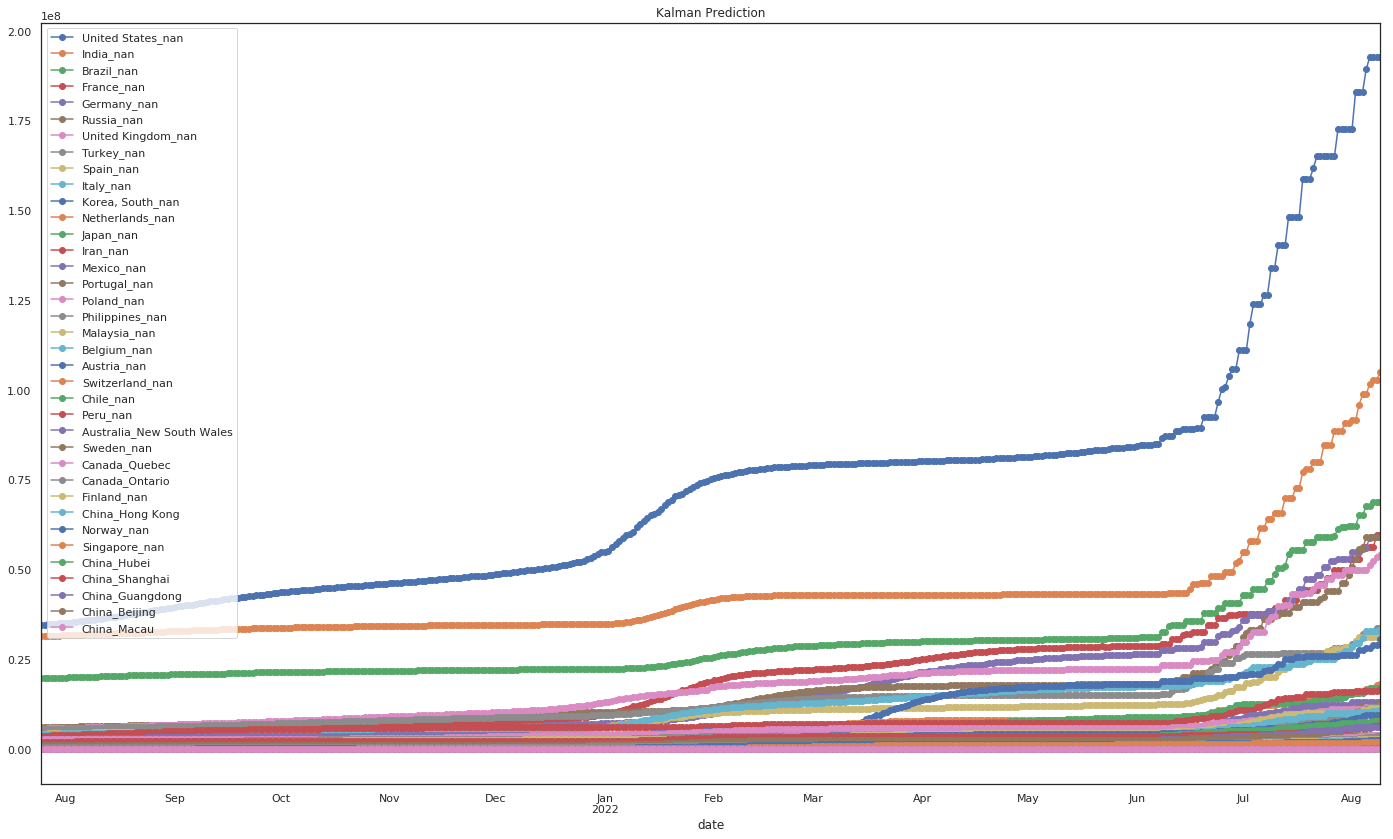

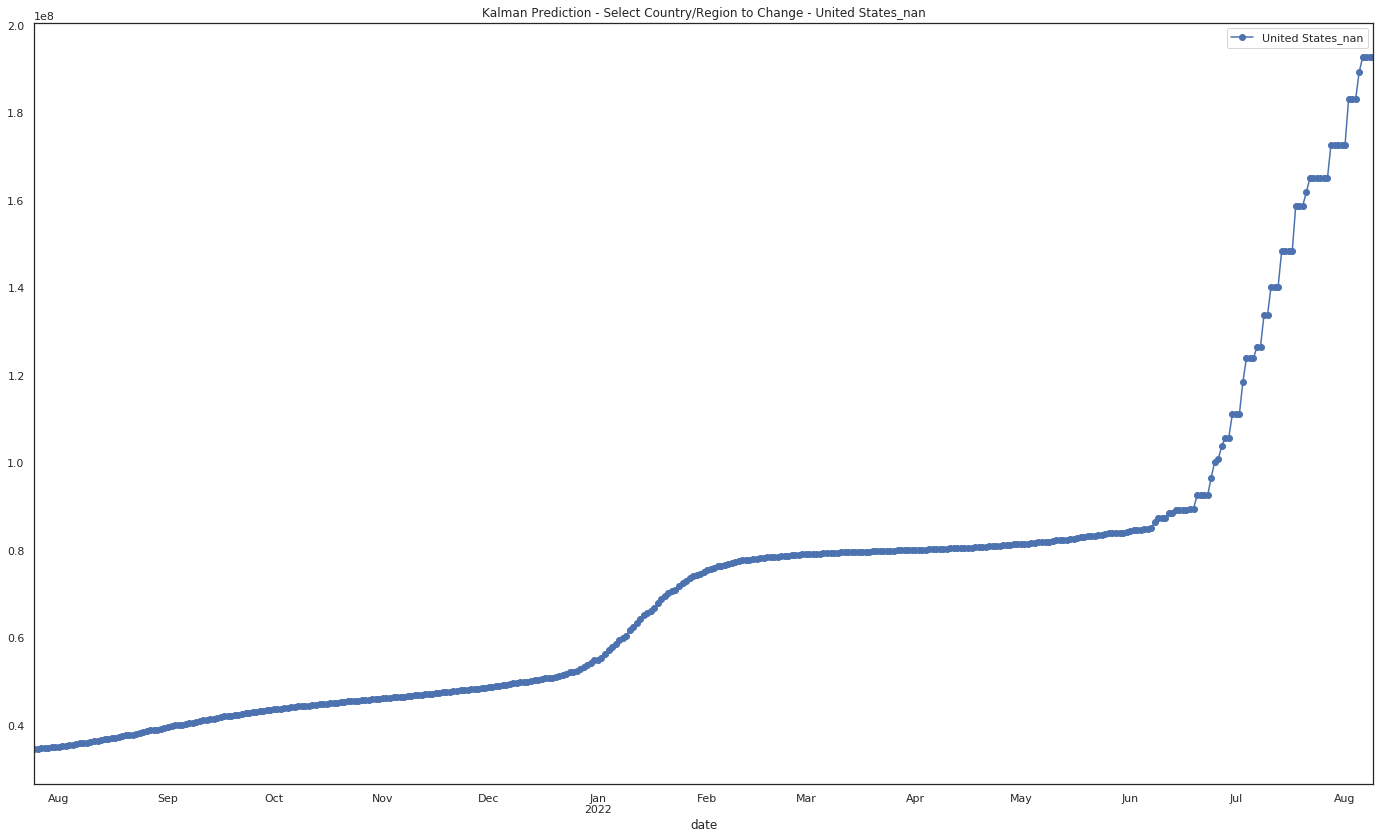

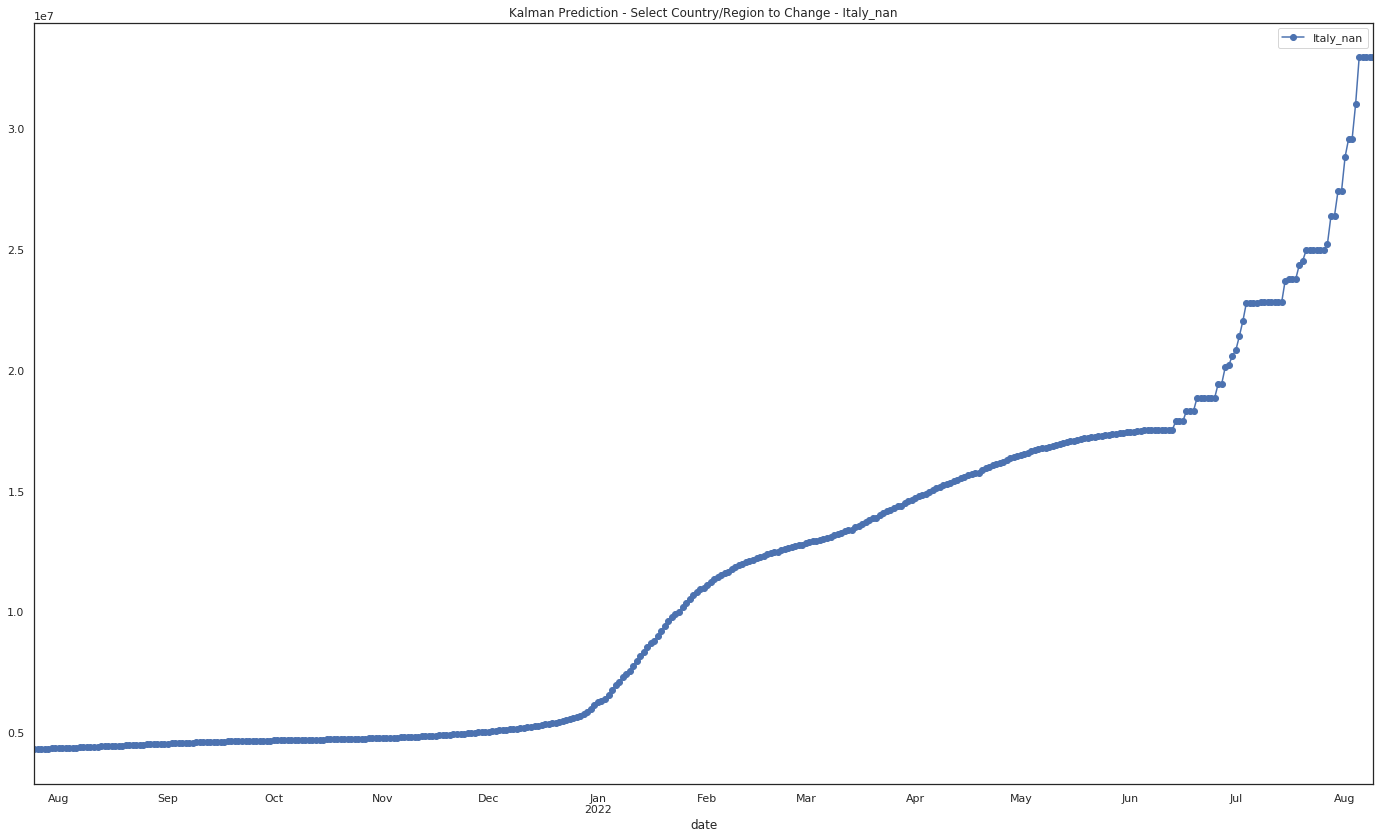

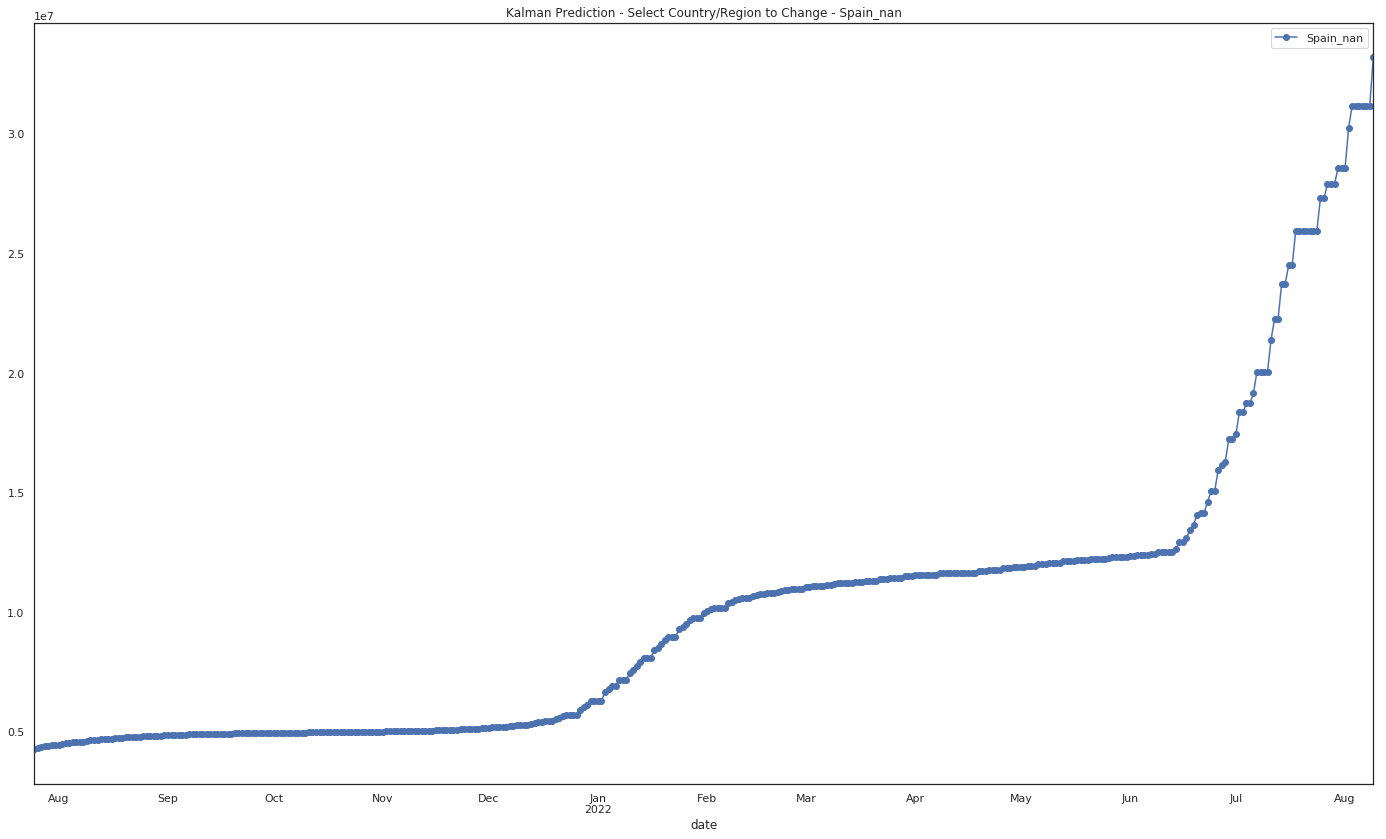

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


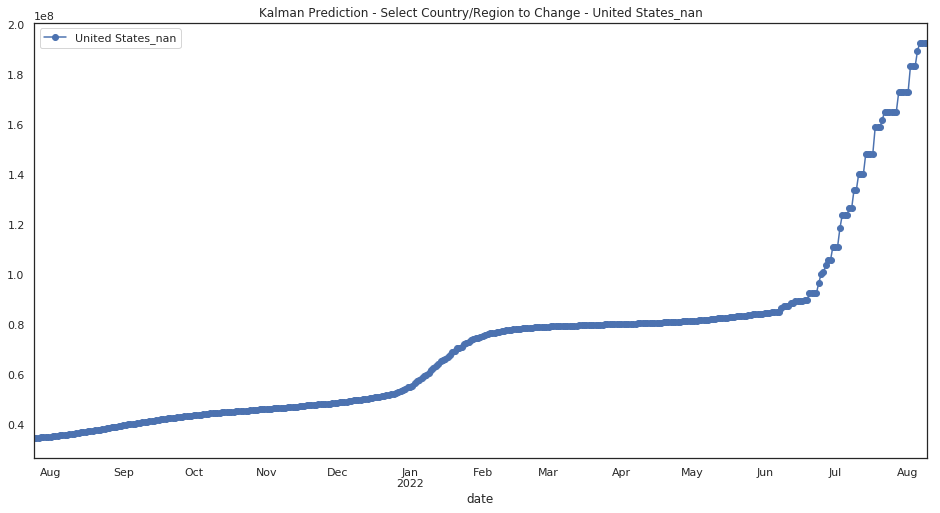

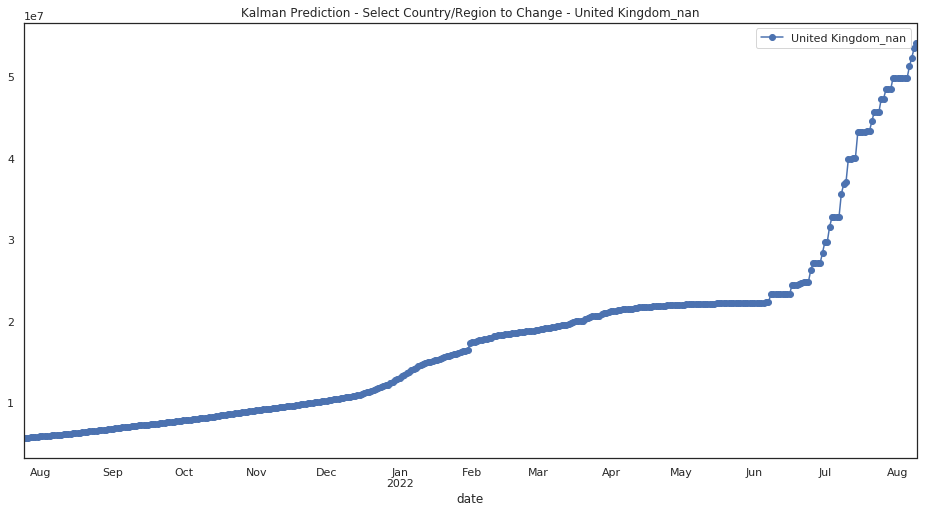

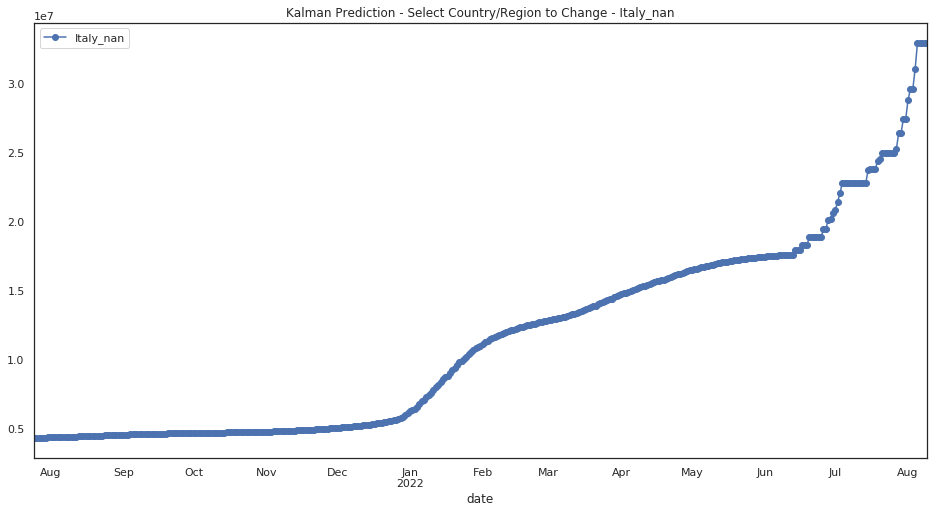

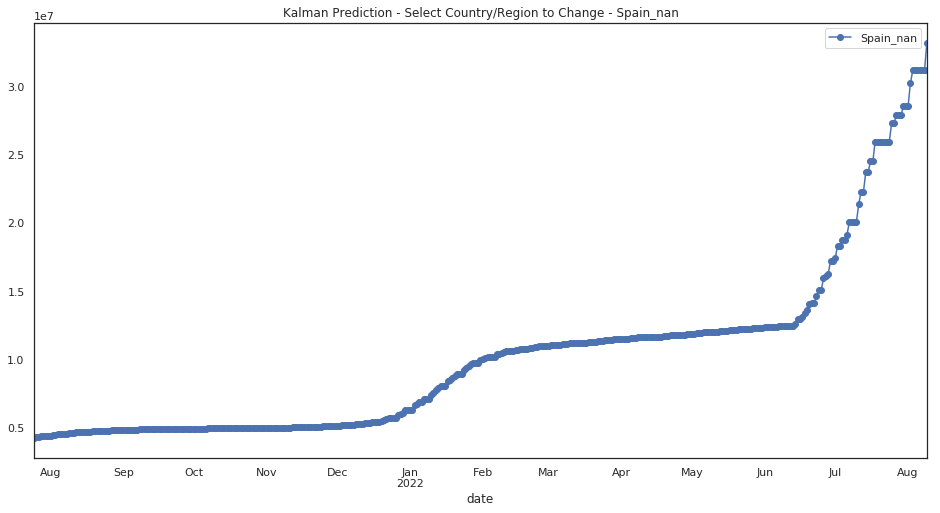

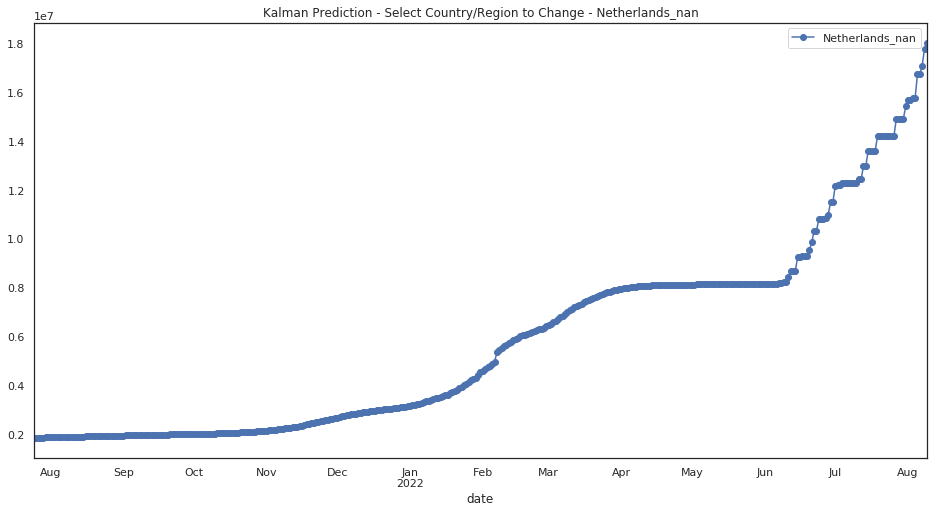

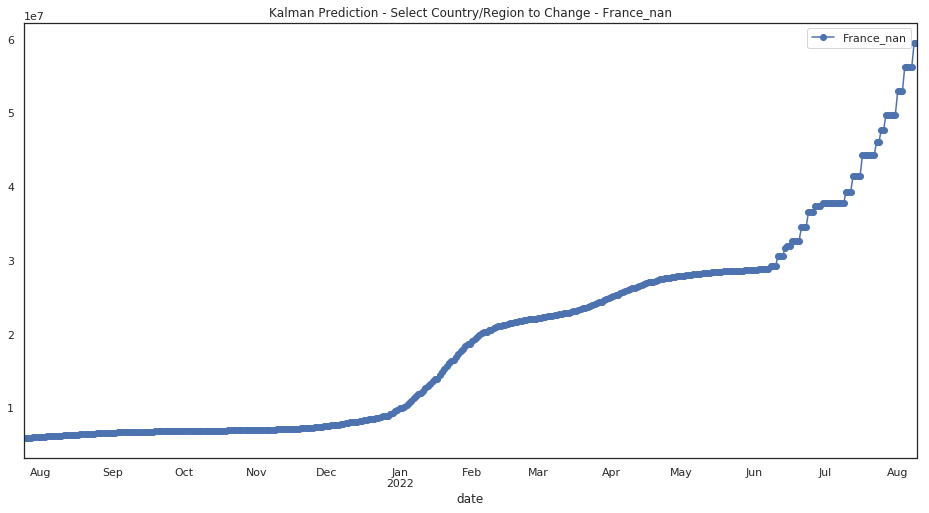

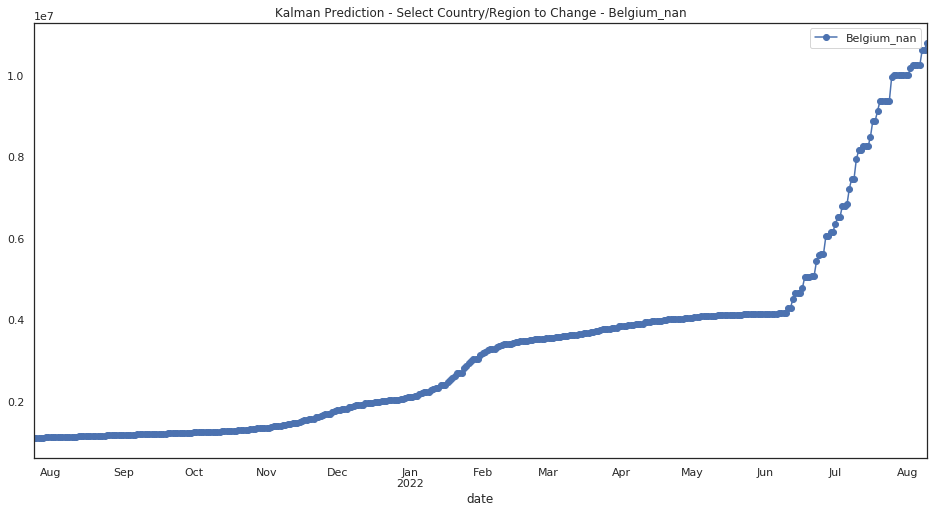

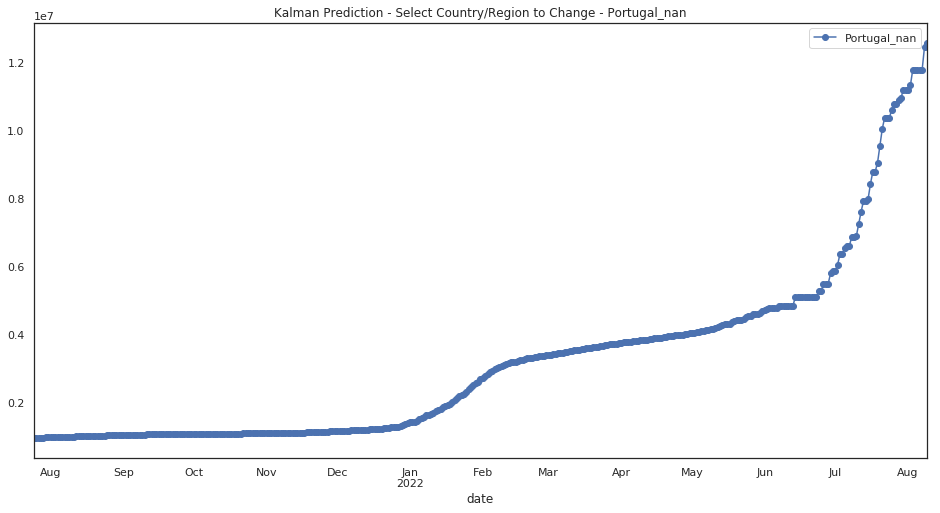

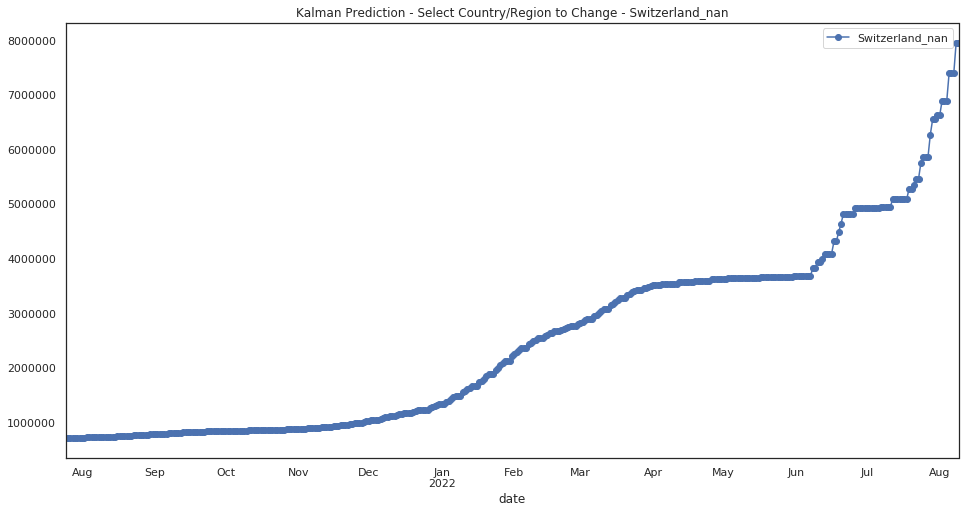

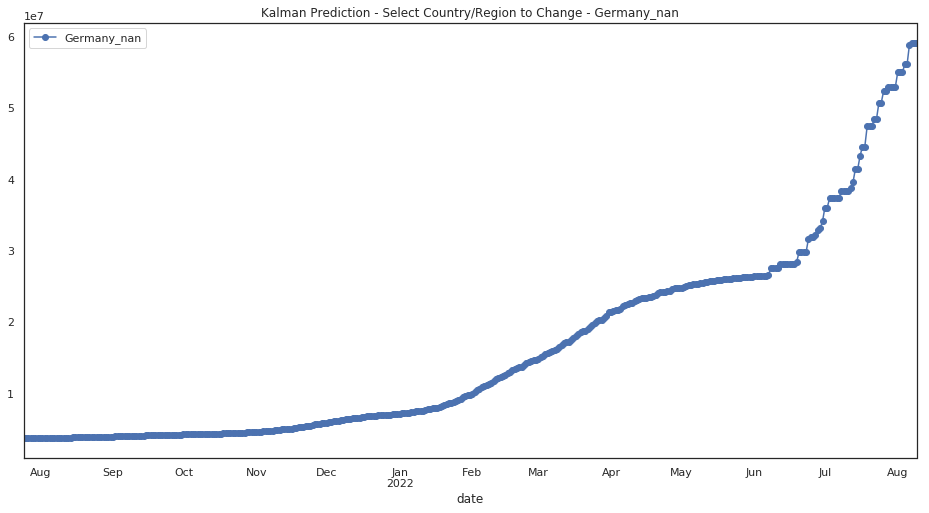

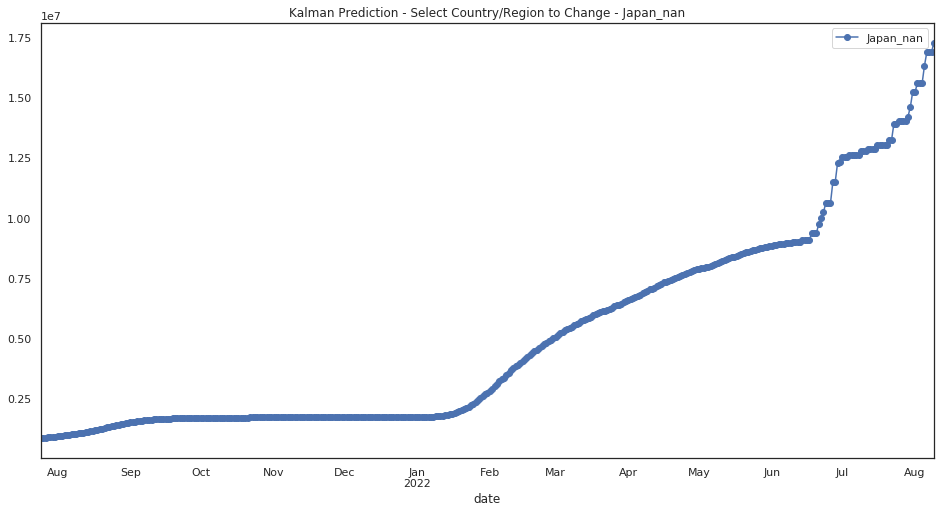

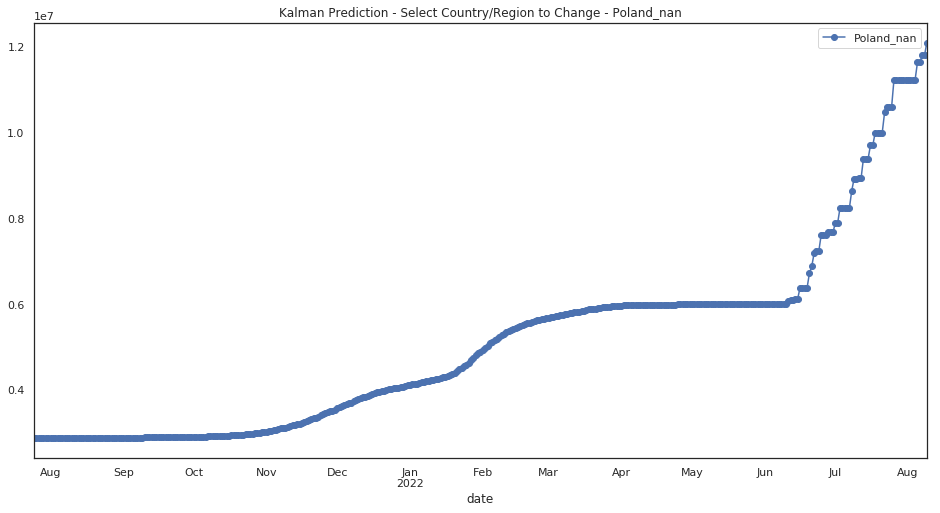

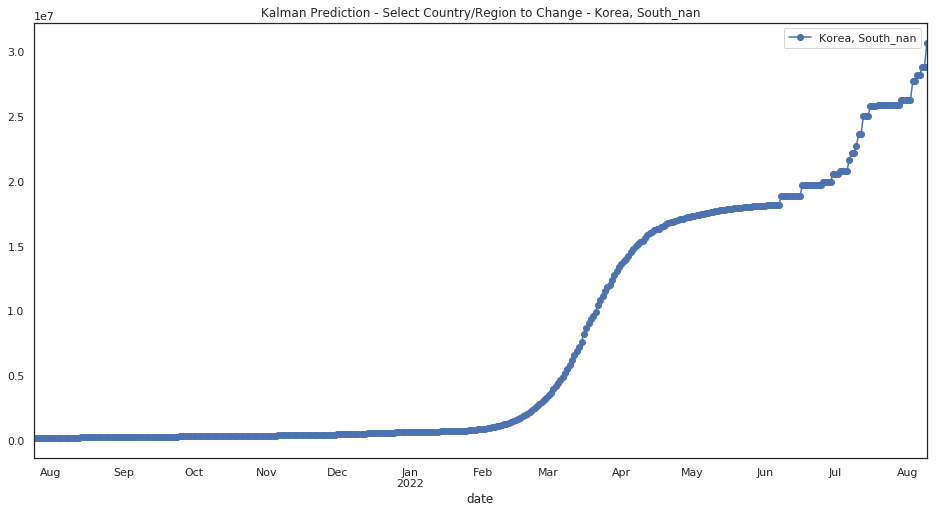

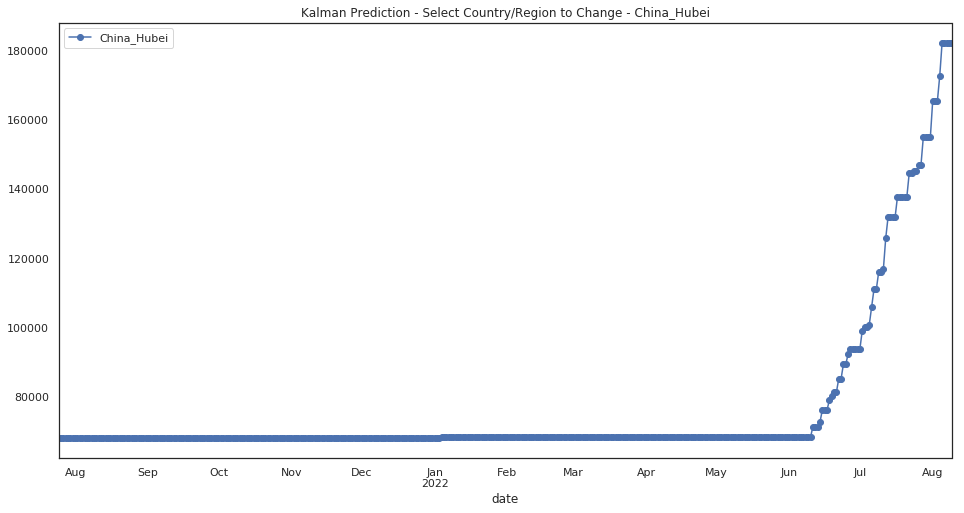

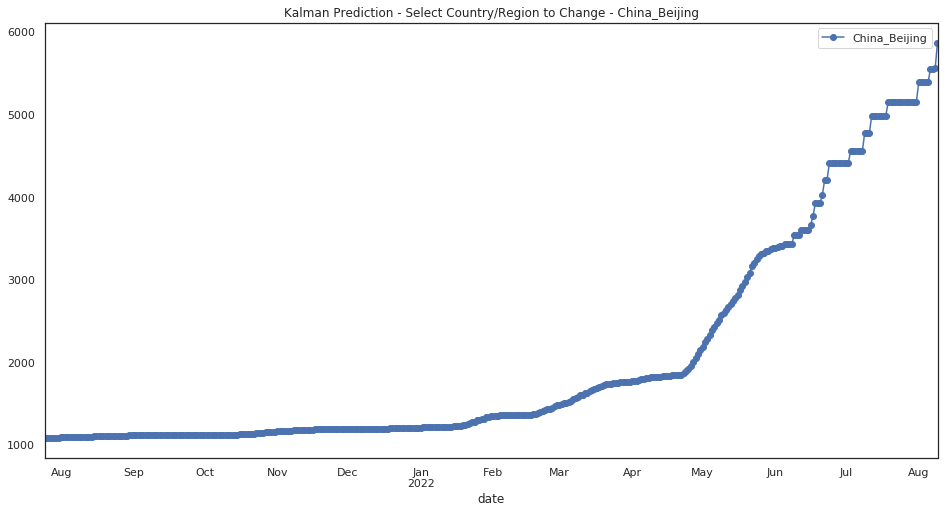

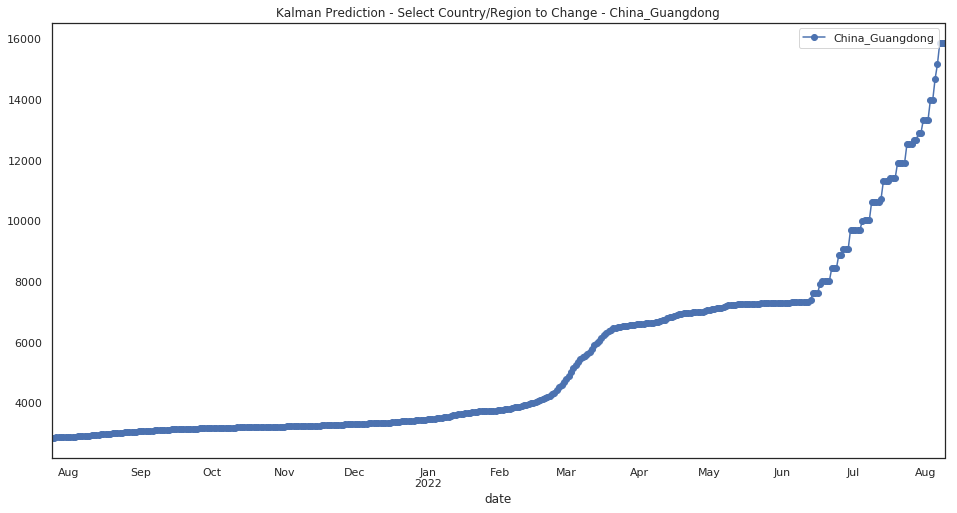

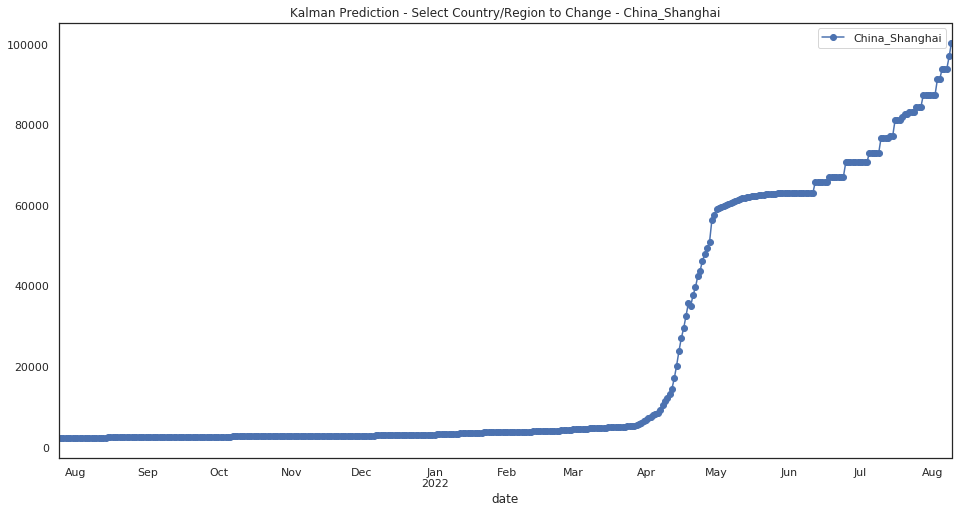

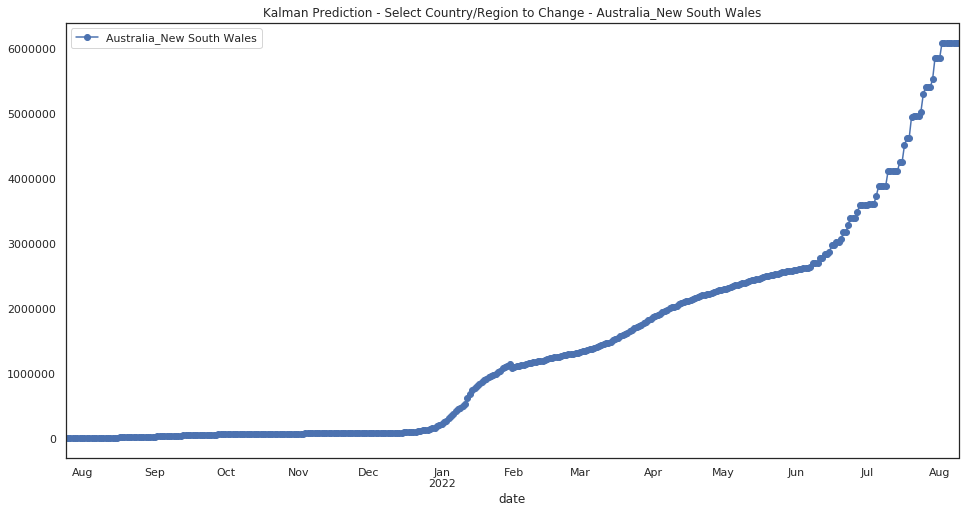

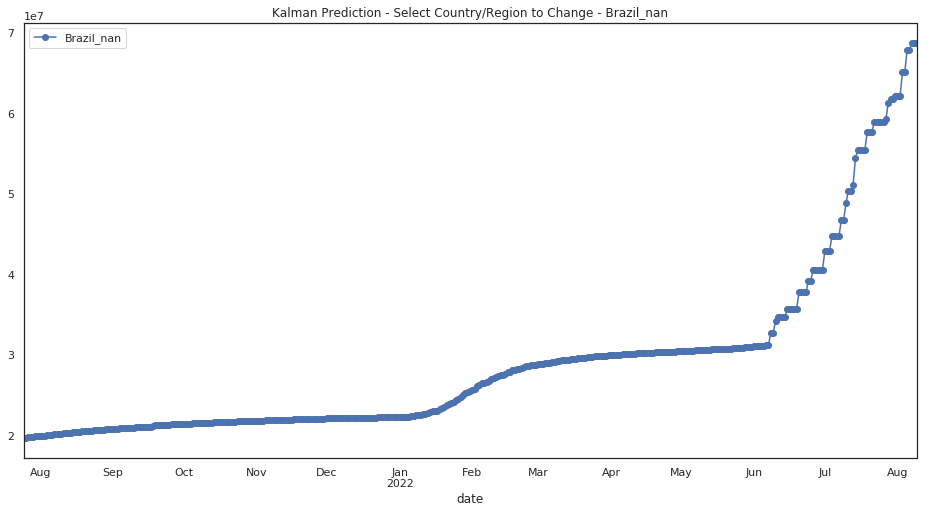

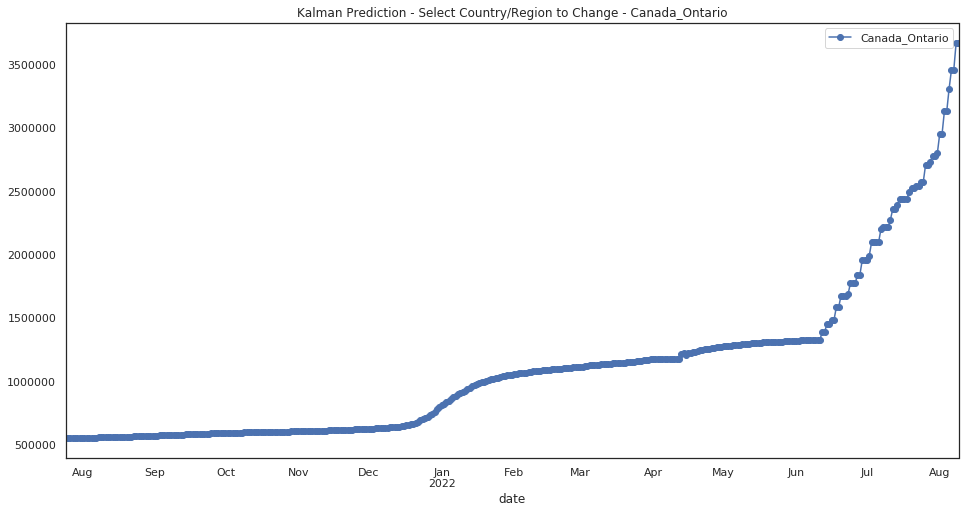

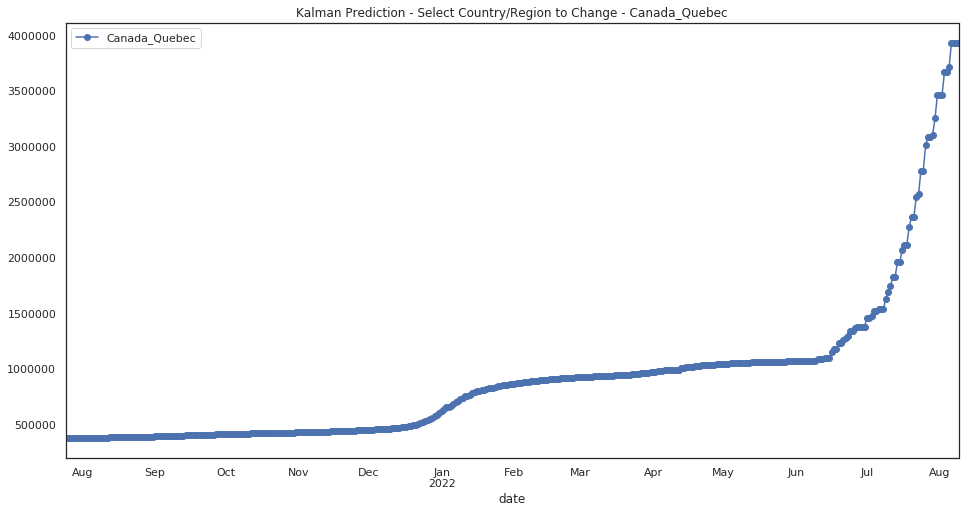

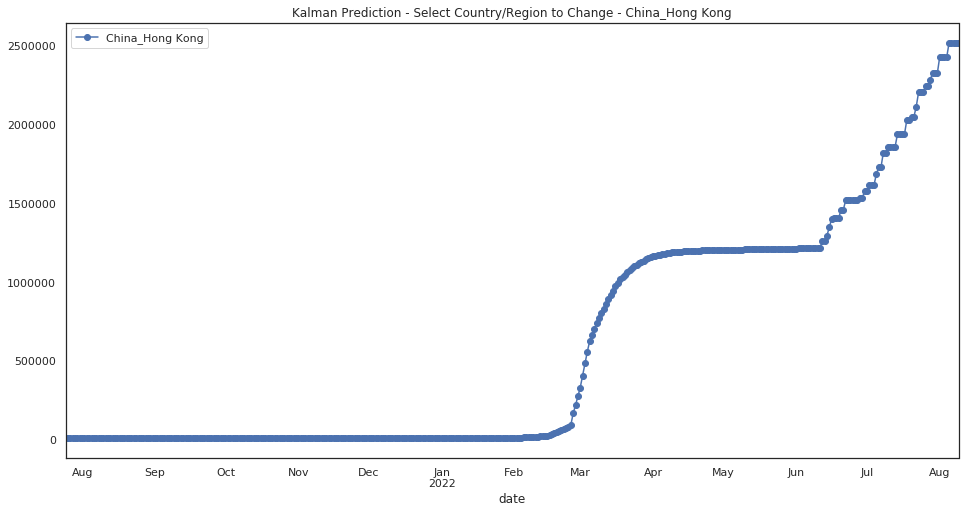

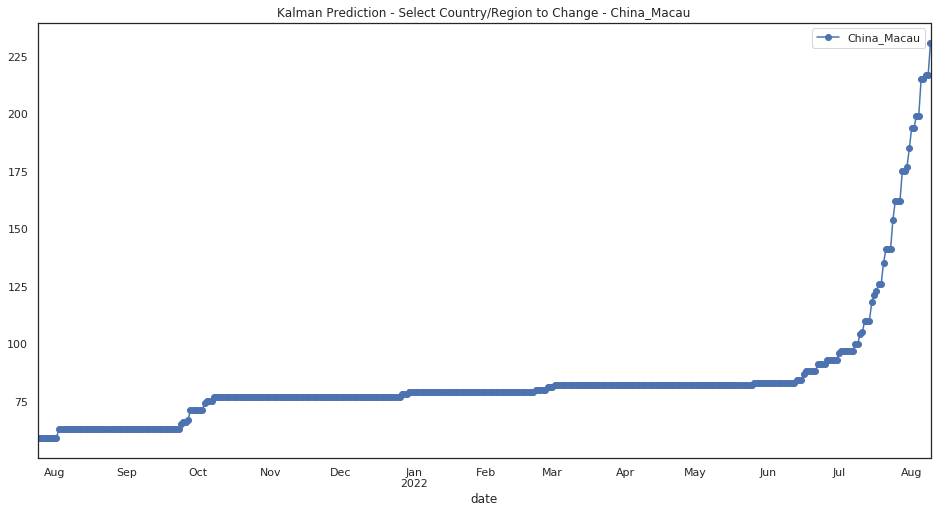

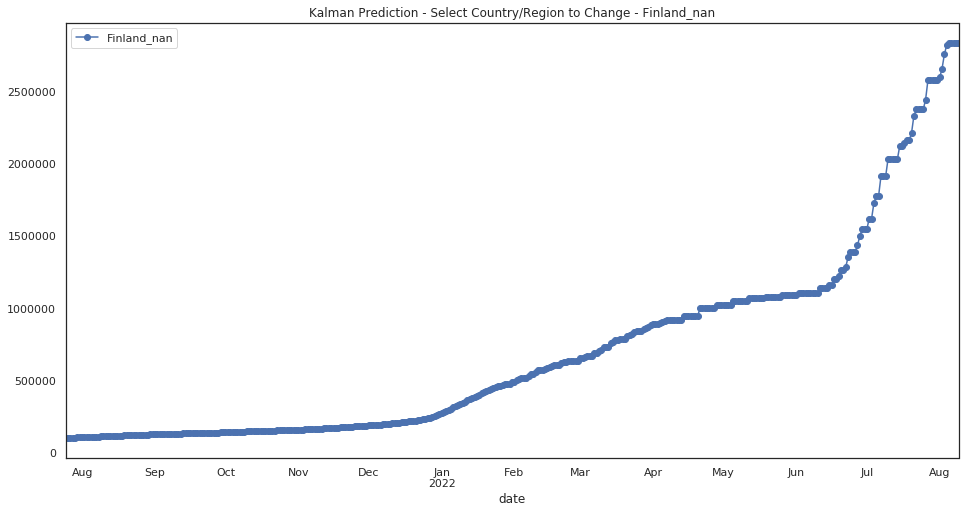

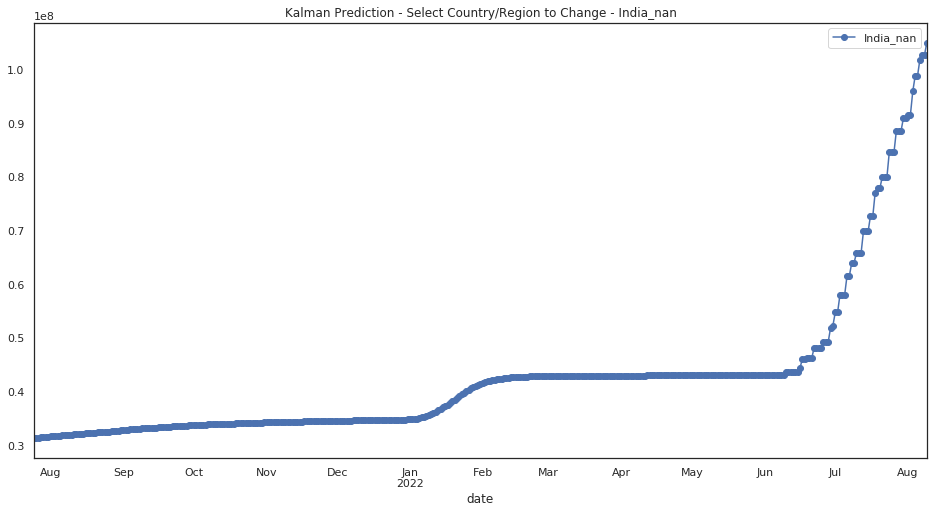

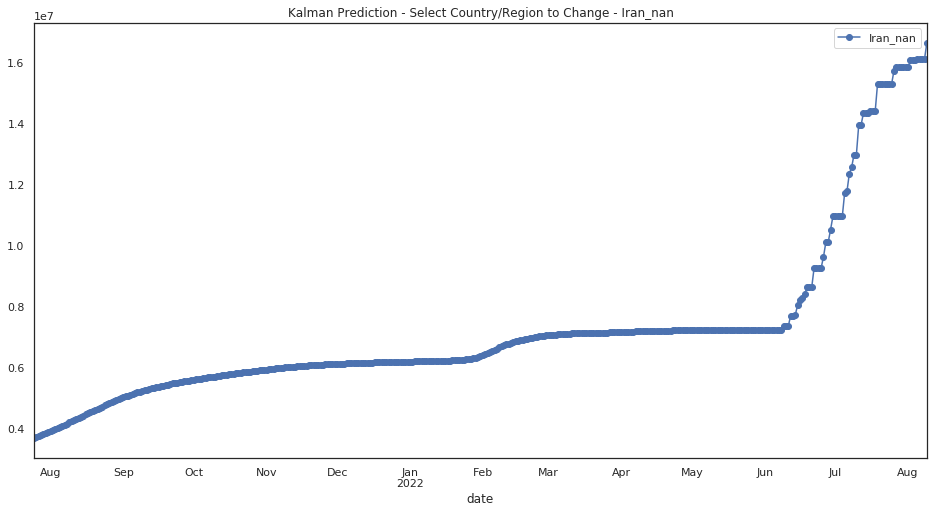

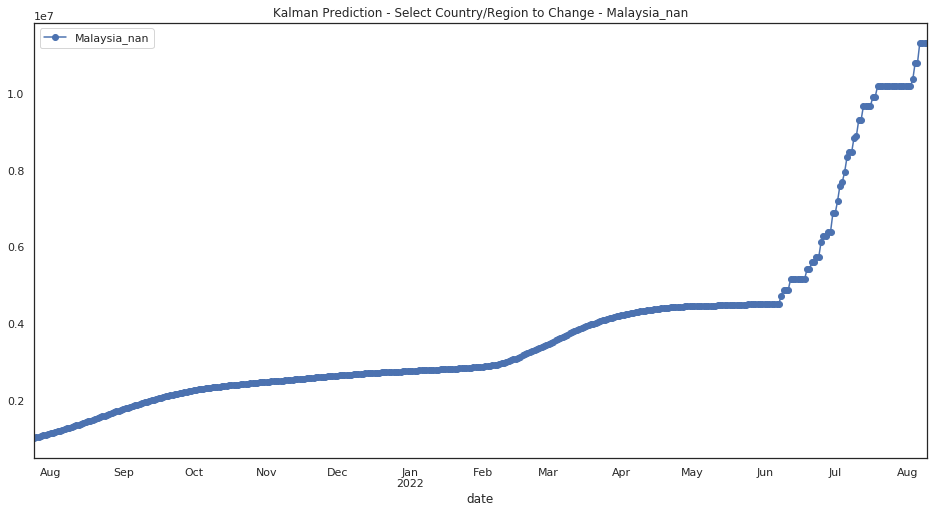

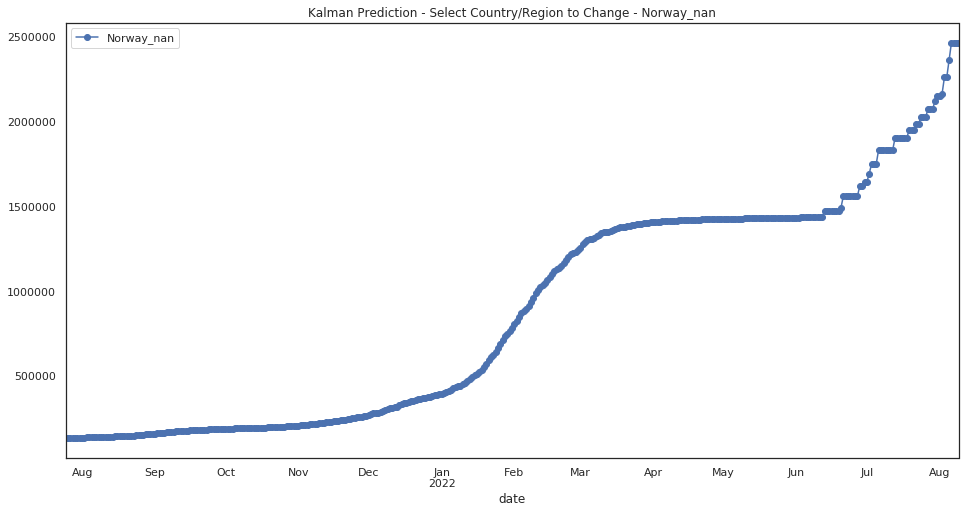

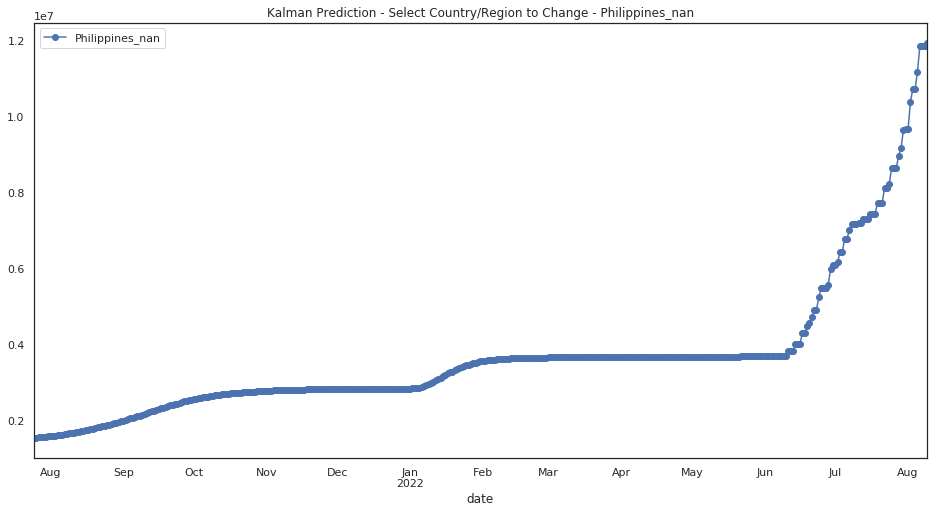

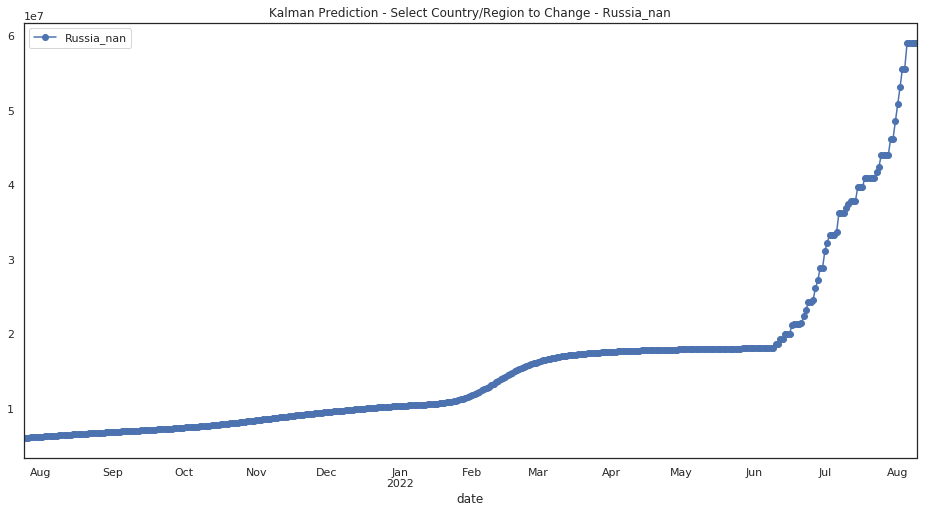

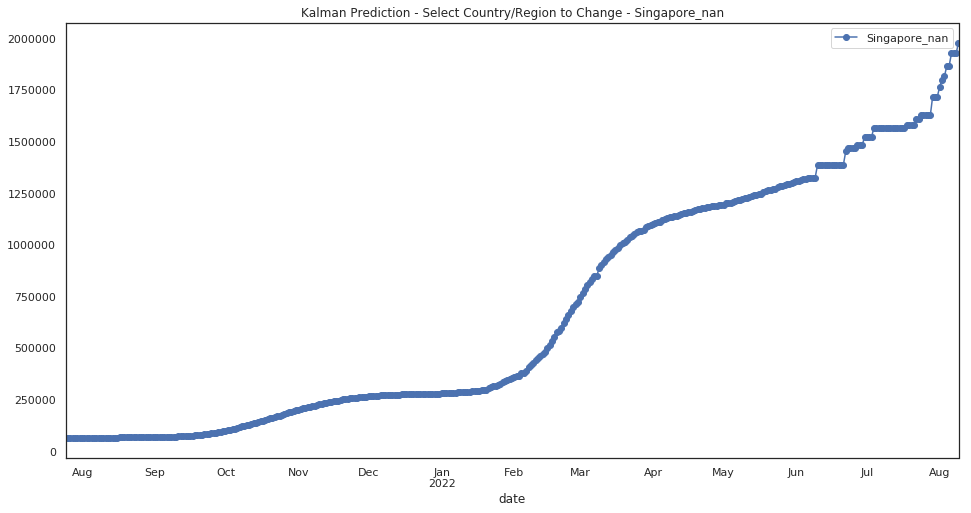

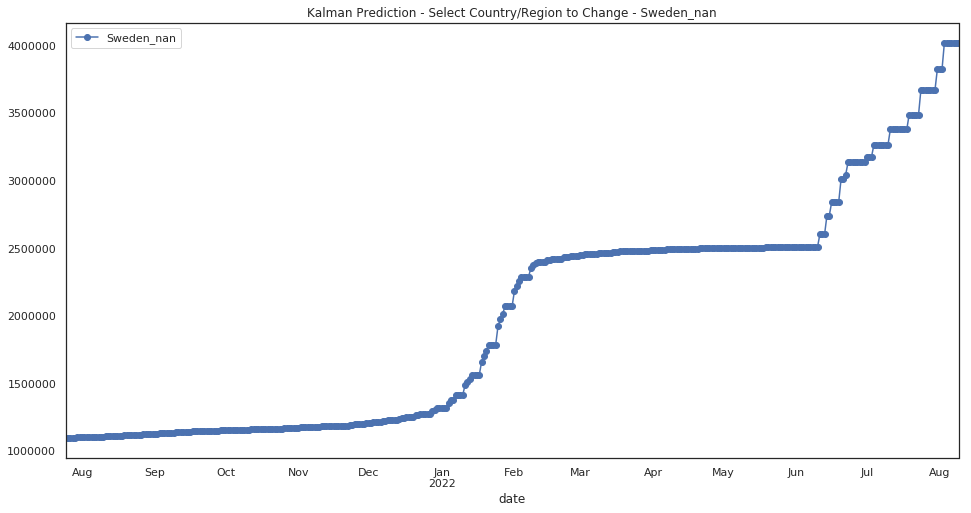

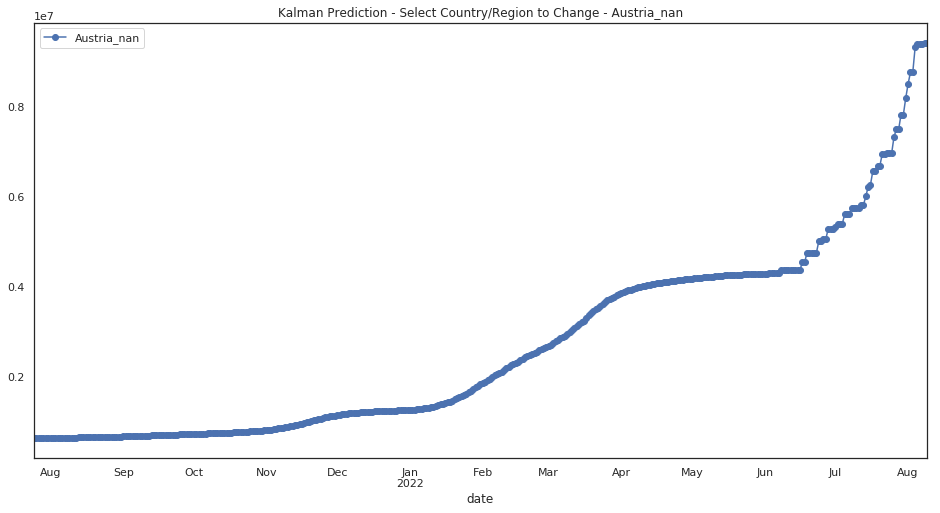

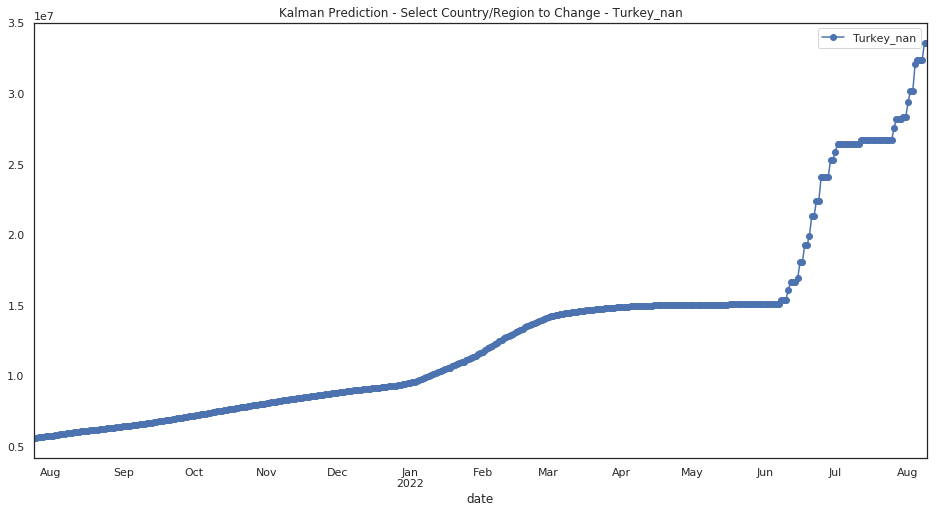

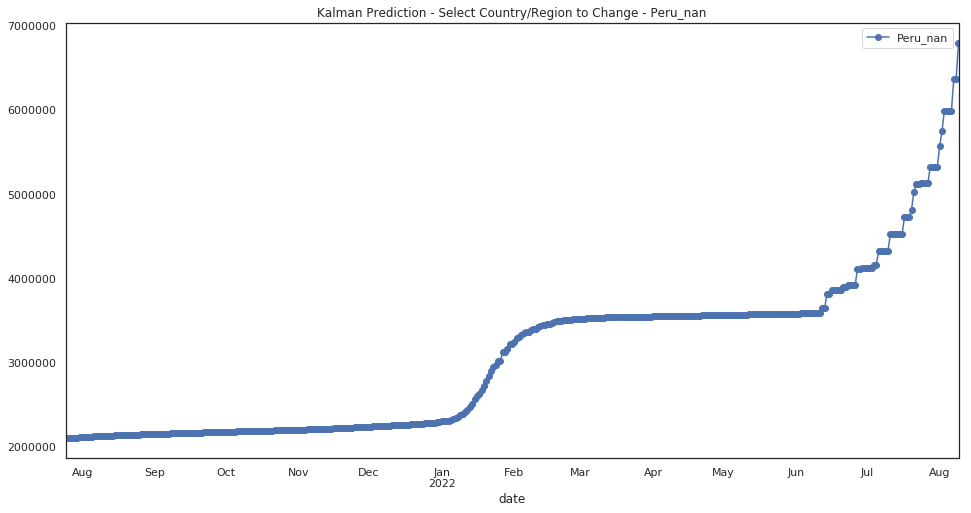

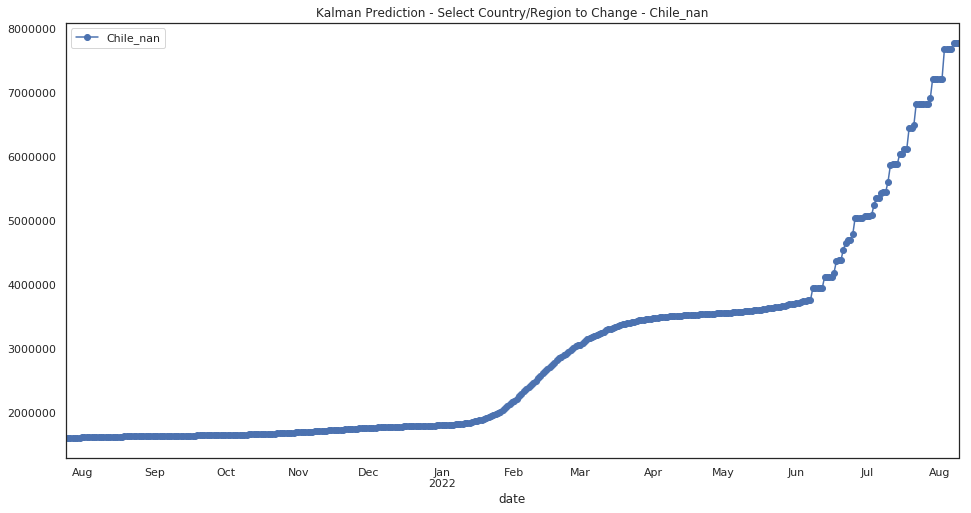

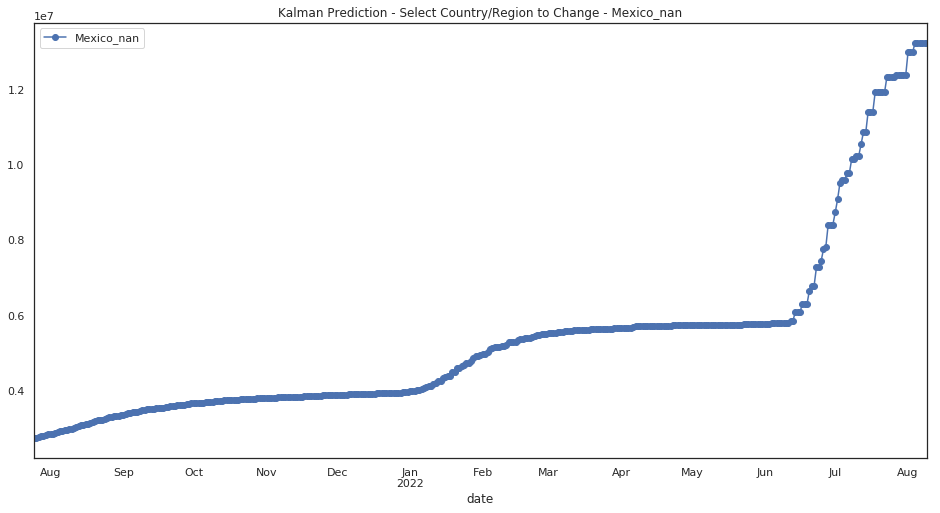

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-08-09 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     192684409.0
India_nan                                           NaN     105033935.0
Brazil_nan                                          NaN      68783641.0
France_nan                                          NaN      59553433.0
Germany_nan                                         NaN      59156076.0
Russia_nan                                          NaN      59083001.0
United Kingdom_nan                                  NaN      54179145.0
Vietnam_nan                                         NaN      52378417.0
Turkey_nan                                          NaN      33614936.0
Spain_nan                                           NaN      33200581.0
Italy_nan                                           NaN      32948920.0
Korea, South_nan                                    NaN      30716862.0
Colombia_nan                                        NaN      27207523.0
Argentina_nan                                       NaN      23126276.0
Netherlands_nan                                     NaN      18051212.0
Japan_nan                                           NaN      17300558.0
Iran_nan                                            NaN      16659431.0
Thailand_nan                                        NaN      14715822.0
Mexico_nan                                          NaN      13243455.0
Indonesia_nan                                       NaN      13090598.0
Portugal_nan                                        NaN      12579510.0
Poland_nan                                          NaN      12093933.0
Philippines_nan                                     NaN      11938611.0
Malaysia_nan                                        NaN      11329554.0
Belgium_nan                                         NaN      10797835.0
Ukraine_nan                                         NaN       9890381.0
Austria_nan                                         NaN       9410333.0
Romania_nan                                         NaN       8705760.0
South Africa_nan                                    NaN       7989462.0
Switzerland_nan                                     NaN       7959262.0
...                                                 ...             ...
China_Hebei                                         NaN          3805.0
China_Jiangxi                                       NaN          3721.0
China_Anhui                                         NaN          3137.0
China_Hunan                                         NaN          3108.0
China_Chongqing                                     NaN          2545.0
United Kingdom_Montserrat                           NaN          2543.0
China_Xinjiang                                      NaN          2401.0
Summer Olympics 2020_nan                            NaN          2000.0
Diamond Princess_nan                                NaN          1592.0
China_Gansu                                         NaN          1411.0
Winter Olympics 2022_nan                            NaN          1291.0
France_Wallis and Futuna                            NaN           771.0
China_Shanxi                                        NaN           650.0
China_Hainan                                        NaN           545.0
China_Guizhou                                       NaN           427.0
China_Qinghai                                       NaN           314.0
China_Ningxia                                       NaN           239.0
China_Macau                                         NaN           231.0
Micronesia_nan                                      NaN            91.0
Holy See_nan                                        NaN            55.0
Marshall Islands_nan                                NaN            54.0
Canada_Grand Princess                               NaN            25.0
Canada_Repatriated Travellers                       NaN            17.0
Antarctica_nan                                      NaN            16.0
MS Zaandam_nan        

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-07-25         196695.0     187251.0     212398.0      85585.0   
2021-07-26         197050.0     187265.0     213690.0      85652.0   
2021-07-27         144285.0     132891.0     163660.0      14577.0   
2021-07-28         145008.0     132922.0     165204.0      14586.0   
2021-07-29         145552.0     132952.0     168019.0      14586.0   
2021-07-30         145996.0     132999.0     169490.0      14655.0   
2021-07-31         146523.0     133036.0     170739.0      14678.0   
2021-08-01         147154.0     133081.0     171853.0      14678.0   
2021-08-02         149092.0     134215.0     174737.0      15109.0   
2021-08-03         149673.0     134273.0     176089.0      14819.0   
2021-08-04         150083.0     134368.0     177566.0      15087.0   
2021-08-05         150489.0     134494.0     178949.0      15054.0   
2021-08-06         150942.0     134640.0     180142.0      15147.0   
2021-08-07         151378.0     134778.0     181292.0      15082.0   
2021-08-08         151636.0     134949.0     182316.0      15199.0   
2021-08-09         151922.0     135030.0     183293.0      15196.0   
2021-08-10         152185.0     135219.0     184286.0      15216.0   
2021-08-11         152462.0     135496.0     185162.0      15074.0   
2021-08-12         152745.0     135767.0     186019.0      15181.0   
2021-08-13         152968.0     136129.0     186901.0      15206.0   
2021-08-14         153149.0     136531.0     187688.0      15205.0   
2021-08-15         153260.0     136920.0     188311.0      15274.0   
2021-08-16         153360.0     137139.0     188994.0      15296.0   
2021-08-17         153473.0     137533.0     189726.0      15171.0   
2021-08-18         153595.0     138008.0     190456.0      15295.0   
2021-08-19         153664.0     138517.0     191168.0      15258.0   
2021-08-20         153705.0     139048.0     191766.0      15308.0   
2021-08-21         153759.0     139683.0     192279.0      15299.0   
2021-08-22         153784.0     140234.0     192702.0      15327.0   
2021-08-23         153847.0     140636.0     193178.0      15338.0   
...                     ...          ...          ...          ...   
2022-07-12         354844.0     345887.0     380325.0      74741.0   
2022-07-13         376103.0     347929.0     382708.0      74741.0   
2022-07-14         377738.0     358009.0     381157.0      75958.0   
2022-07-15         374334.0     358308.0     392795.0      77917.0   
2022-07-16         375726.0     357385.0     399049.0      77917.0   
2022-07-17         380752.0     357385.0     411723.0      77917.0   
2022-07-18         384351.0     357385.0     422404.0      77917.0   
2022-07-19         391224.0     357385.0     414404.0      78499.0   
2022-07-20         398123.0     367405.0     414404.0      81195.0   
2022-07-21         394179.0     373825.0     414404.0      81195.0   
2022-07-22         394179.0     369409.0     422173.0      84410.0   
2022-07-23         394244.0     385800.0     428164.0      84410.0   
2022-07-24         407775.0     395242.0     444986.0      89030.0   
2022-07-25         416292.0     388533.0     459248.0      89030.0   
2022-07-26         409934.0     394725.0     453348.0      89895.0   
2022-07-27         410281.0     405309.0     456492.0      89895.0   
2022-07-28         431365.0     412002.0     467237.0      89961.0   
2022-07-29         444195.0     412323.0     475720.0      89961.0   
2022-07-30         434617.0     411295.0     480008.0      89961.0   
2022-07-31         454617.0     435268.0     510252.0      89961.0   
2022-08-01         468453.0     450209.0     524705.0      91166.0   
2022-08-02         459223.0     440185.0     524720.0      91166.0   
2022-08-03         459223.0     456808.0     529371.0      92303.0   
2022-08-04         459223.0     468567.0     526913.0      92303.0   
2022-08-05

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Germany_nan',
 'Russia_nan',
 'United Kingdom_nan',
 'Vietnam_nan',
 'Turkey_nan',
 'Spain_nan',
 'Italy_nan',
 'Korea, South_nan',
 'Colombia_nan',
 'Argentina_nan',
 'Netherlands_nan',
 'Japan_nan',
 'Iran_nan',
 'Thailand_nan',
 'Mexico_nan',
 'Indonesia_nan',
 'Portugal_nan',
 'Poland_nan',
 'Philippines_nan',
 'Malaysia_nan',
 'Belgium_nan',
 'Ukraine_nan',
 'Austria_nan',
 'Romania_nan',
 'South Africa_nan',
 'Switzerland_nan',
 'Serbia_nan',
 'Chile_nan',
 'Israel_nan',
 'Czechia_nan',
 'Greece_nan',
 'Peru_nan',
 'Denmark_nan',
 'Australia_New South Wales',
 'Taiwan*_nan',
 'Australia_Victoria',
 'Bangladesh_nan',
 'Slovakia_nan',
 'Iraq_nan',
 'Sweden_nan',
 'Canada_Quebec',
 'Pakistan_nan',
 'Georgia_nan',
 'Canada_Ontario',
 'Hungary_nan',
 'Jordan_nan',
 'Kazakhstan_nan',
 'Cuba_nan',
 'Ethiopia_nan',
 'Ireland_nan',
 'Finland_nan',
 'Latvia_nan',
 'New Zealand_nan',
 'Lithuania_nan',
 'Nepal_nan',
 'Austra

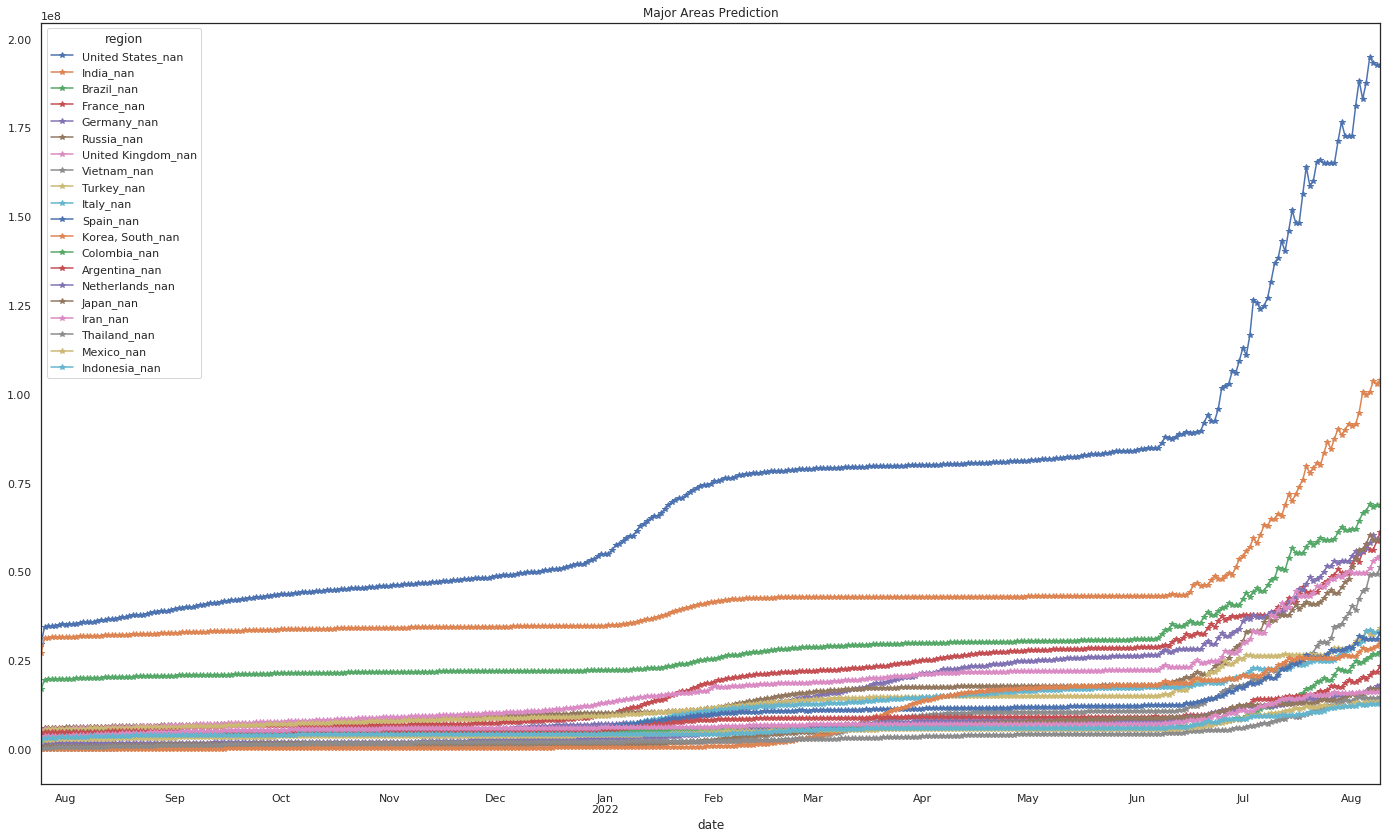

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

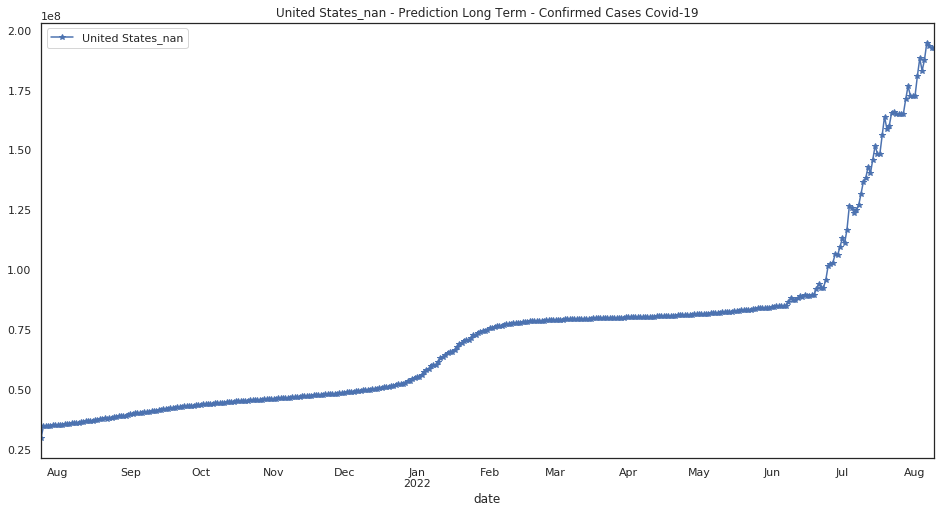

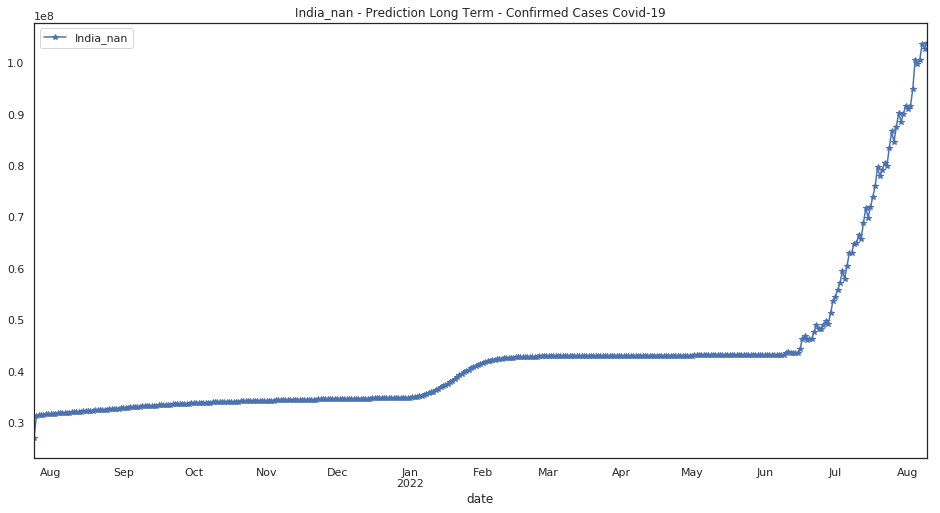

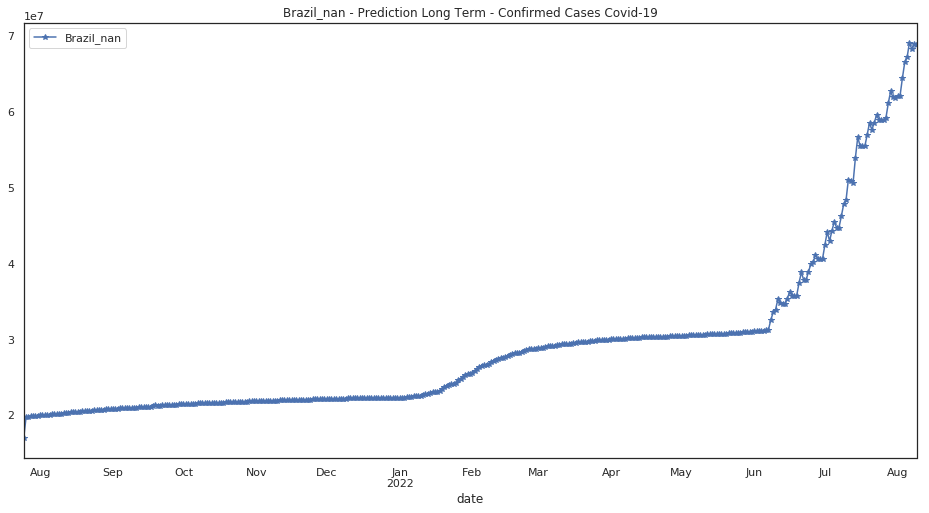

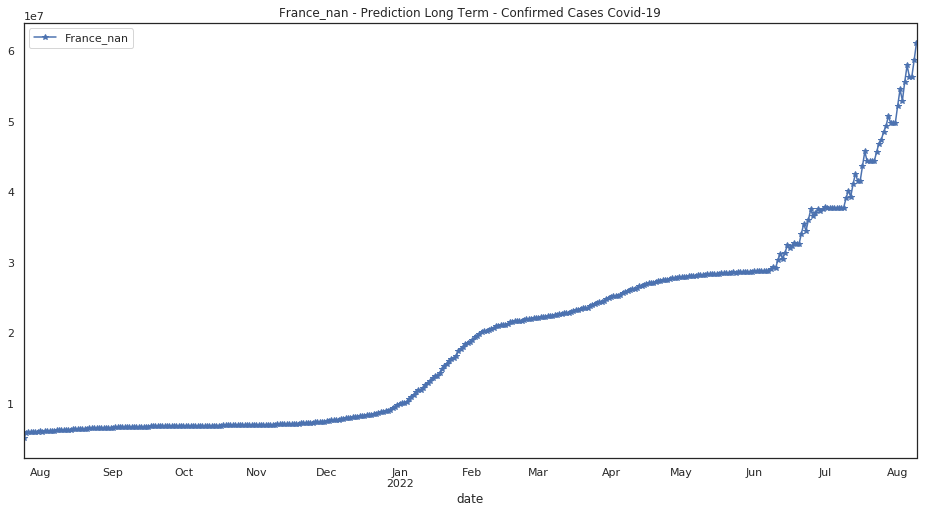

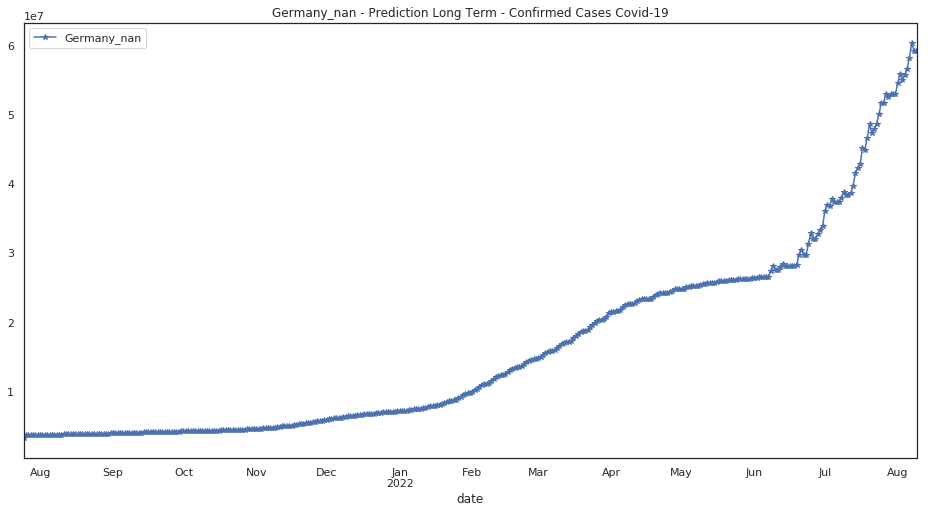

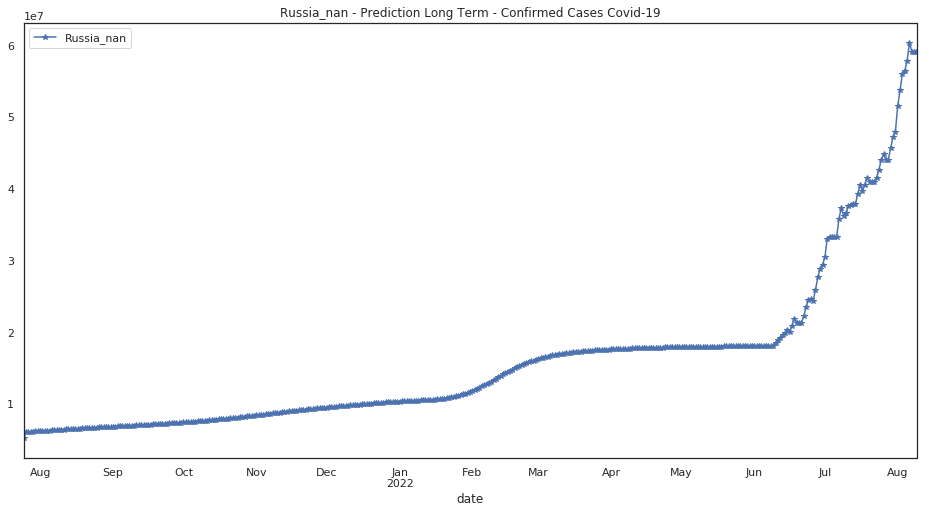

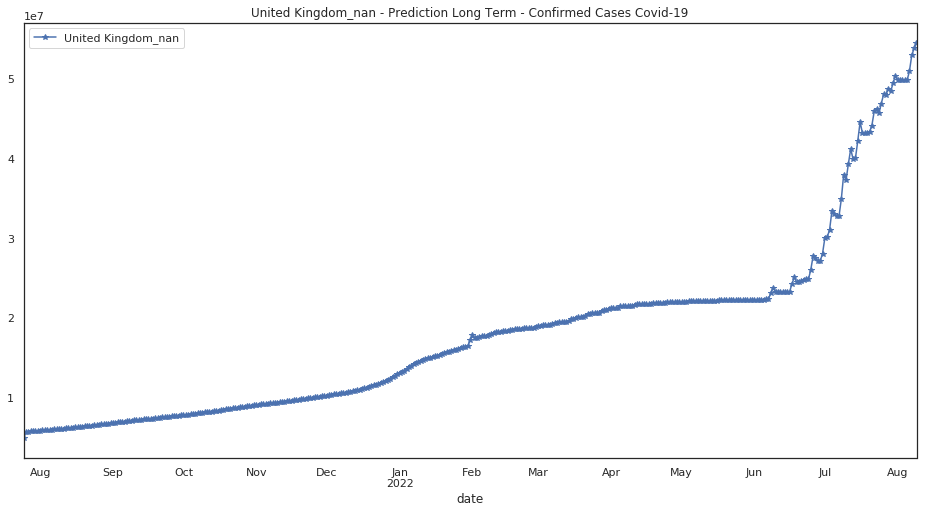

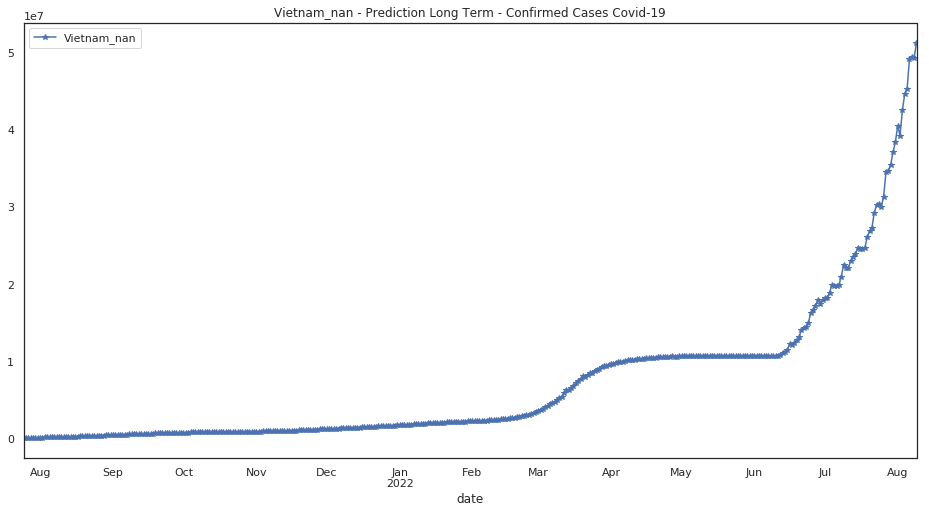

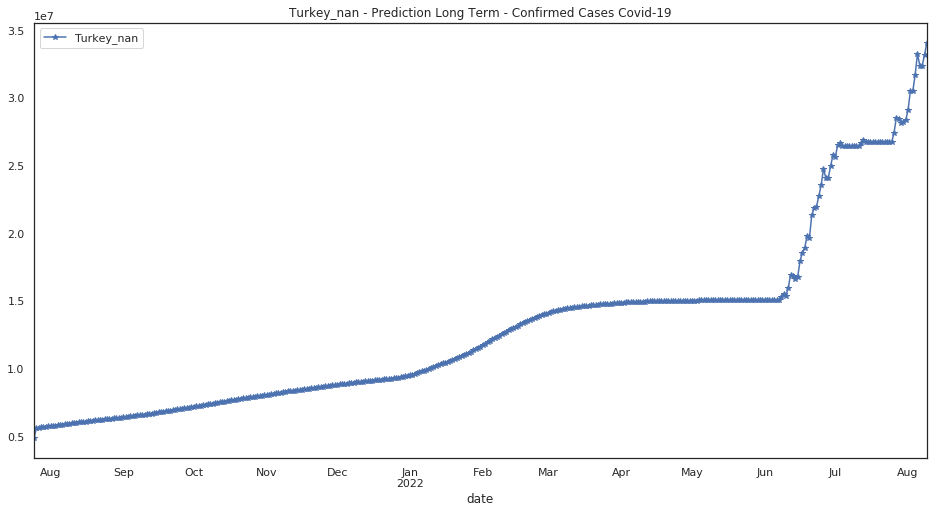

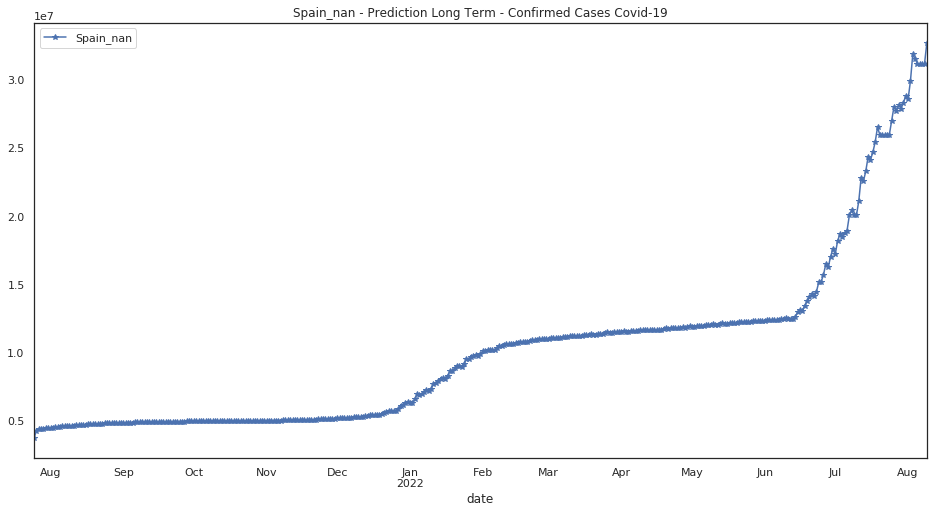

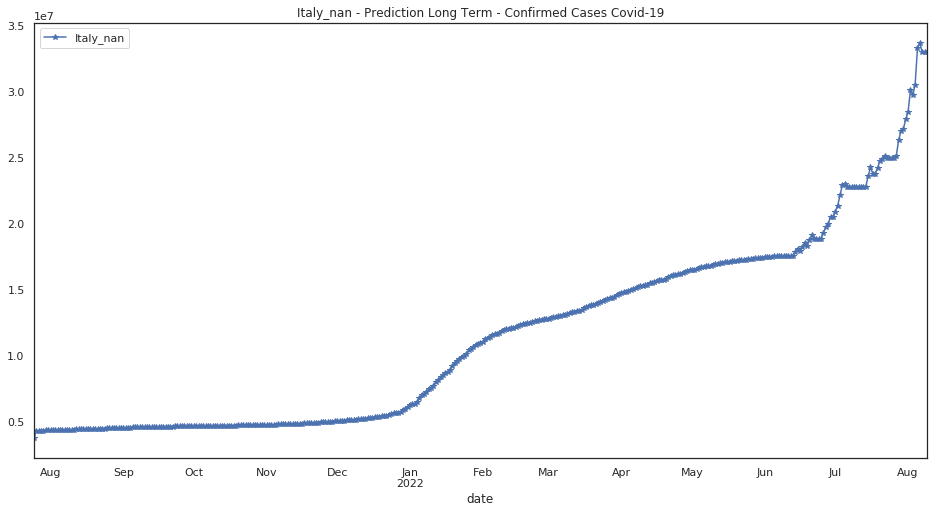

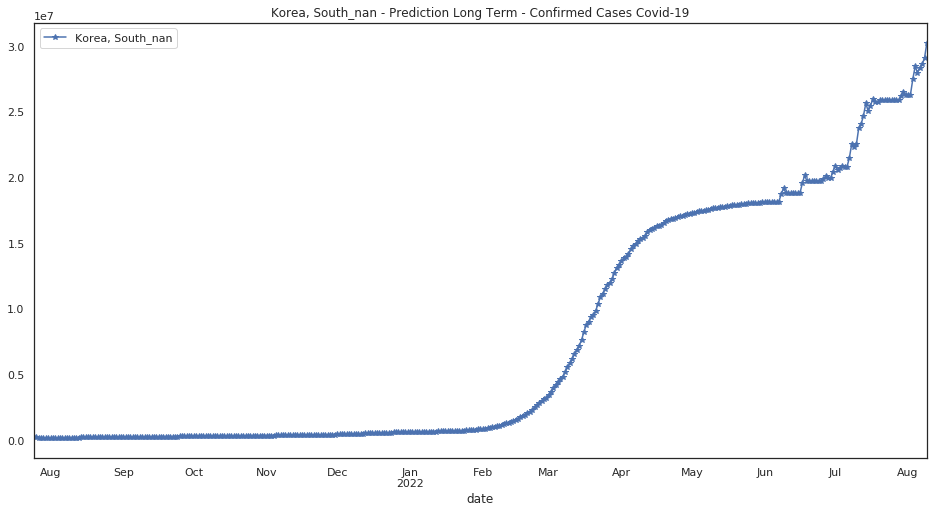

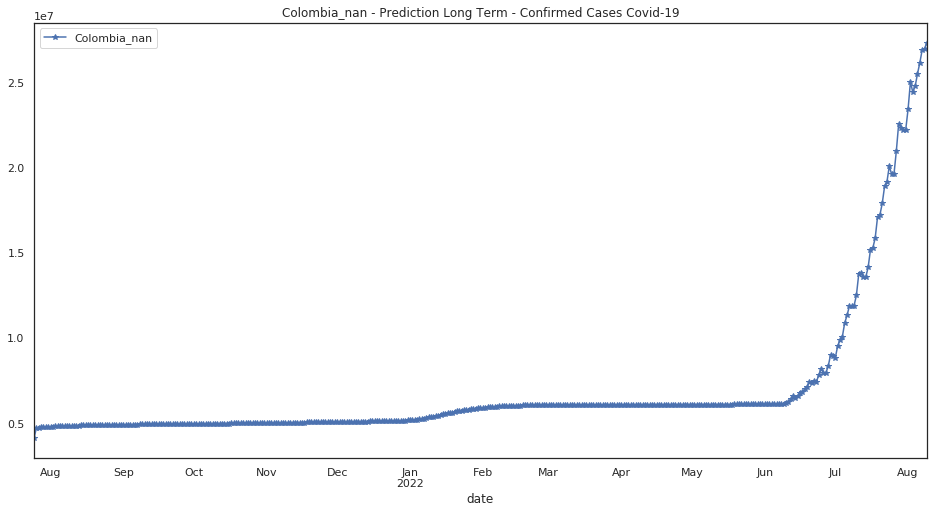

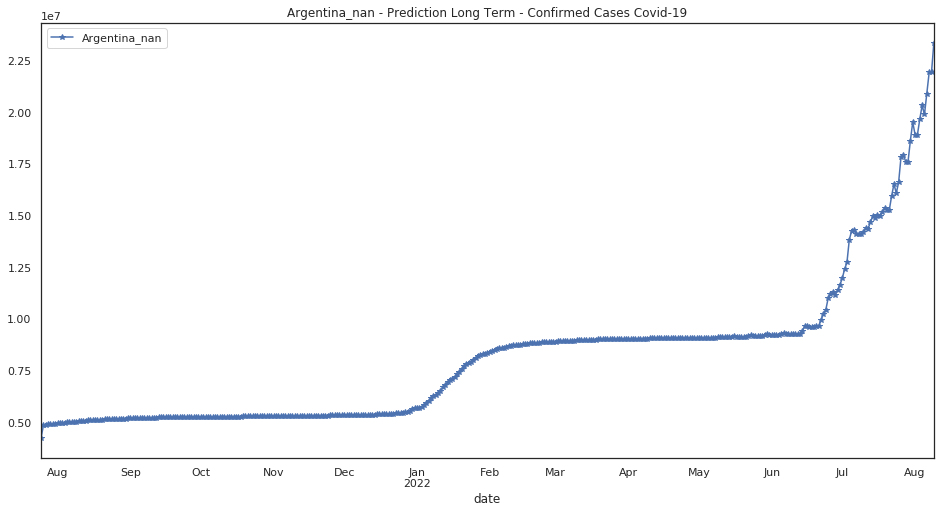

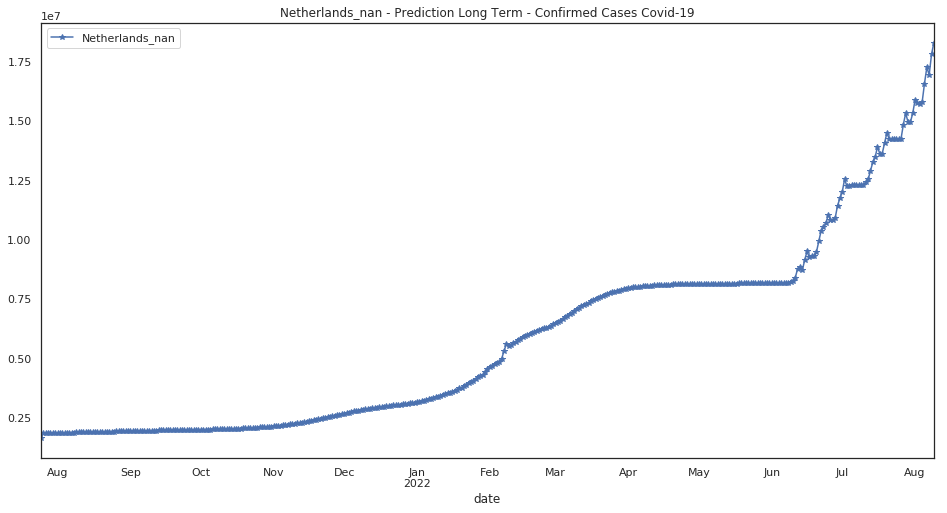

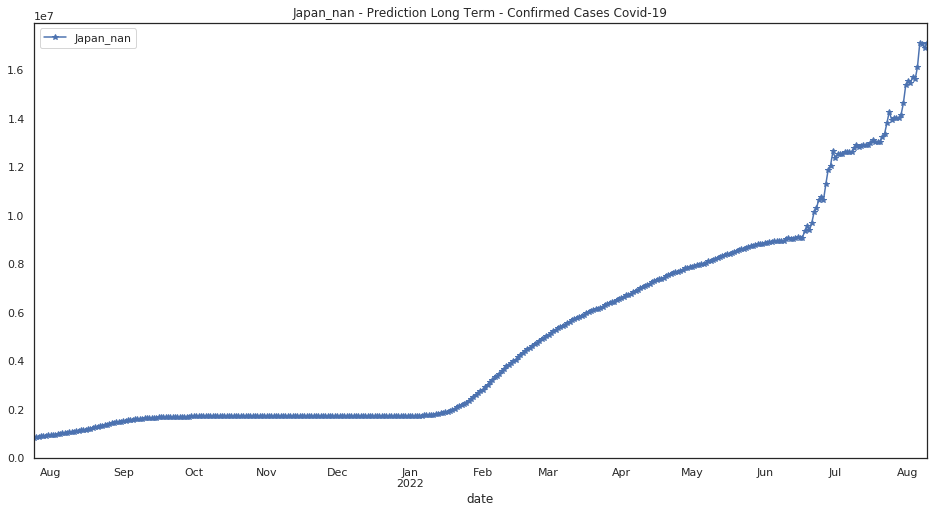

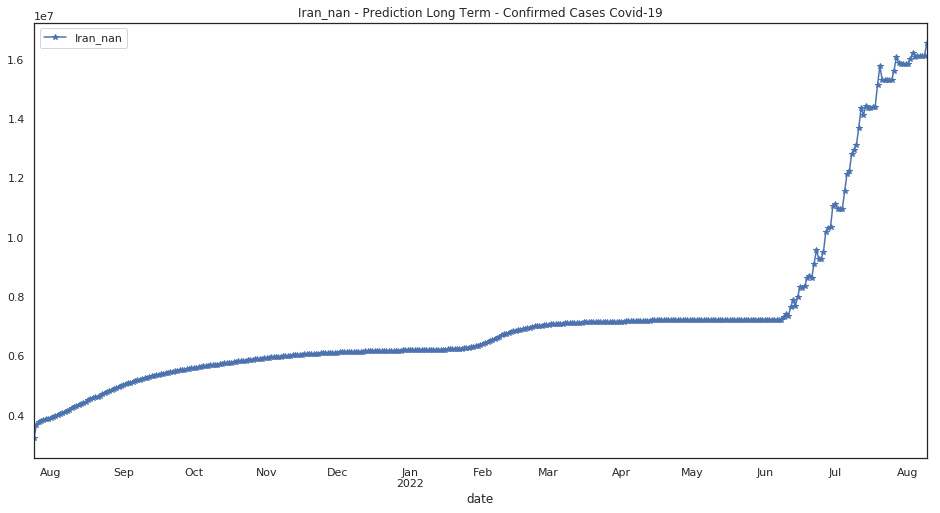

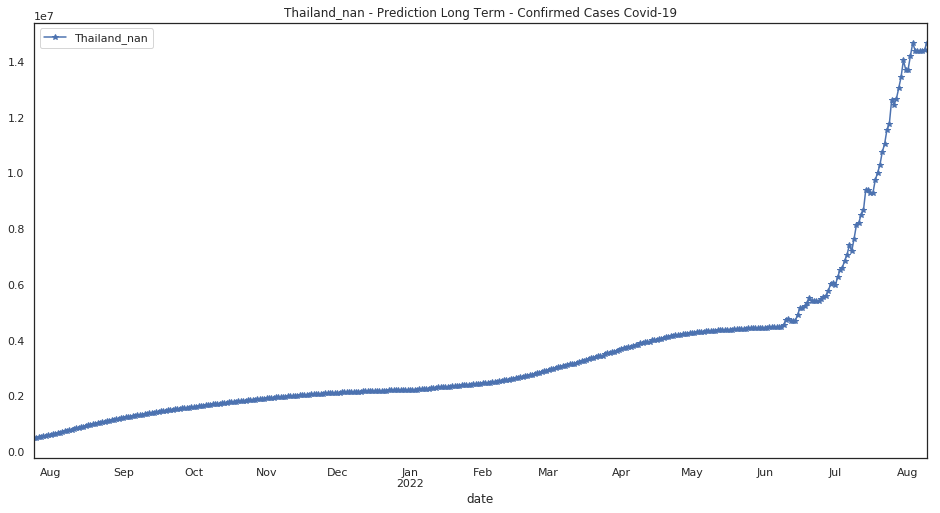

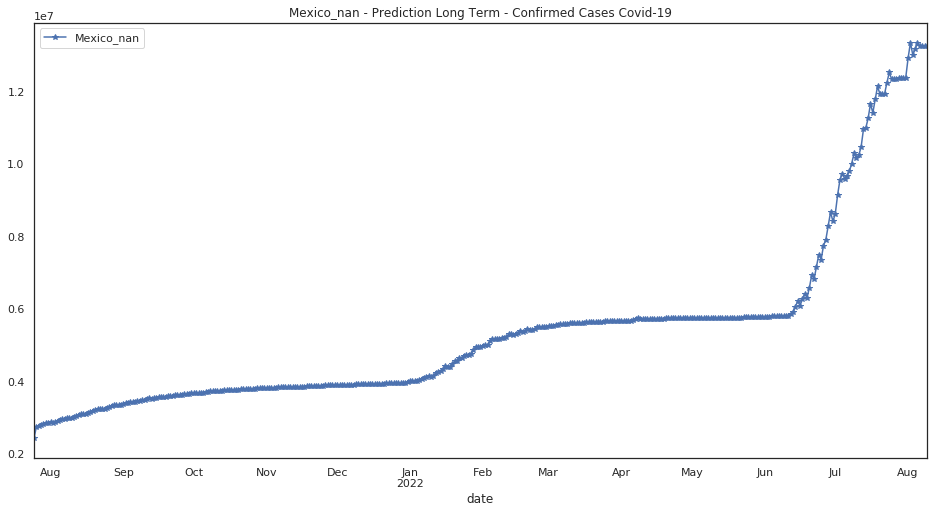

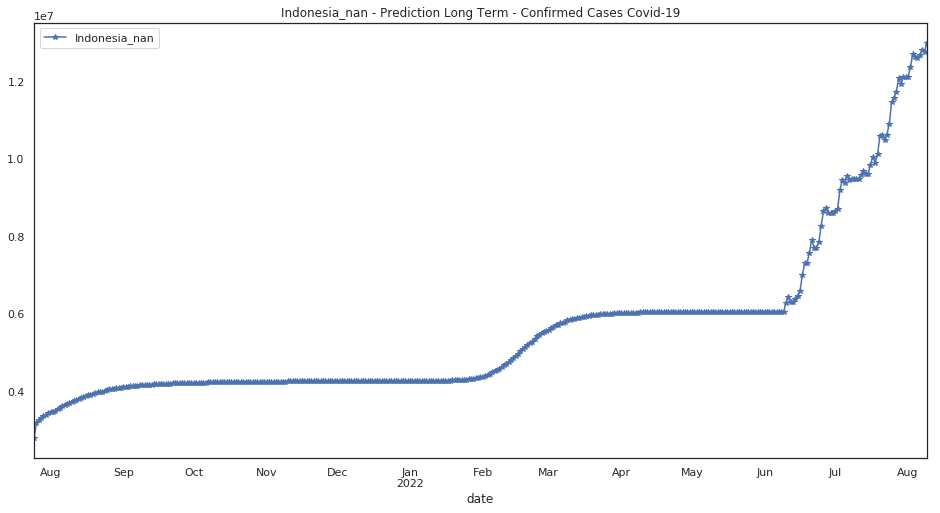

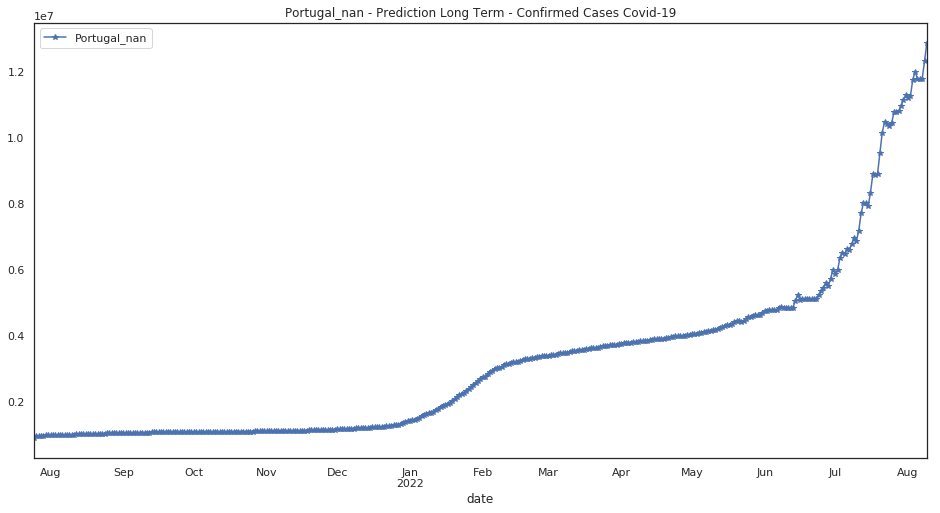

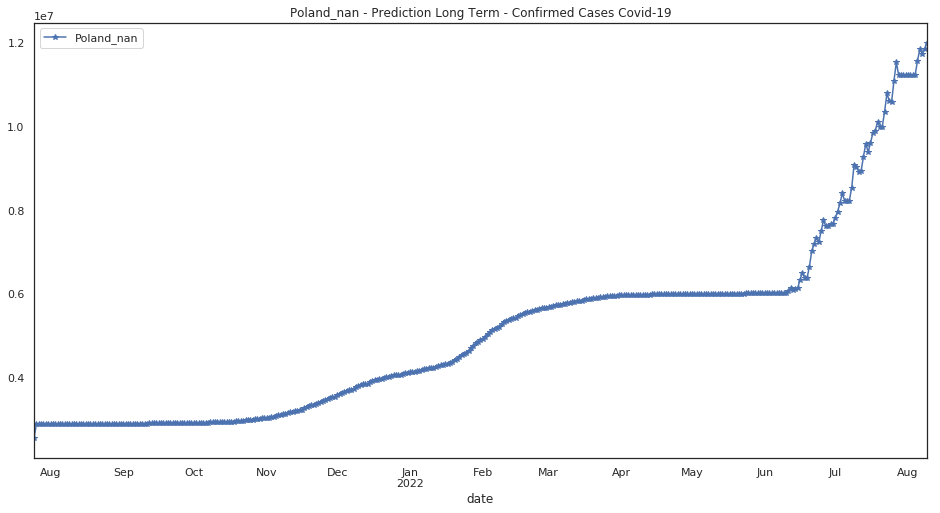

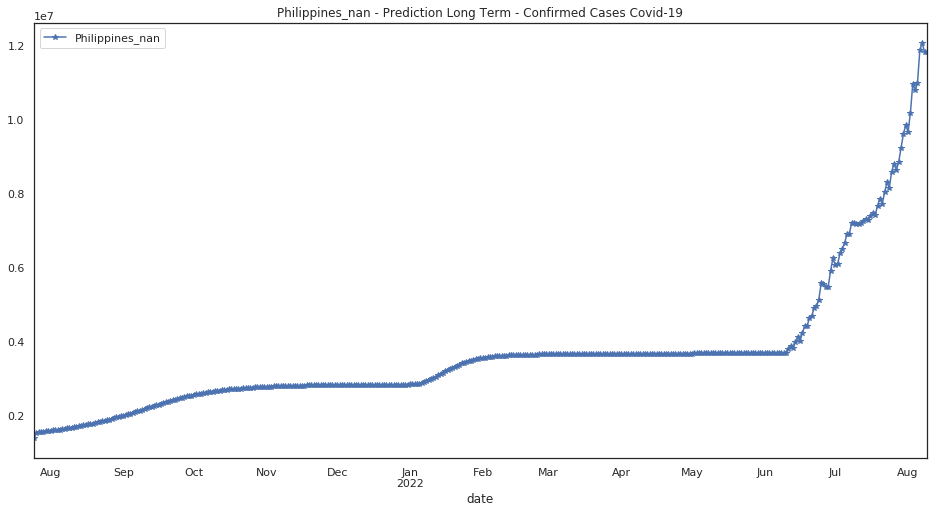

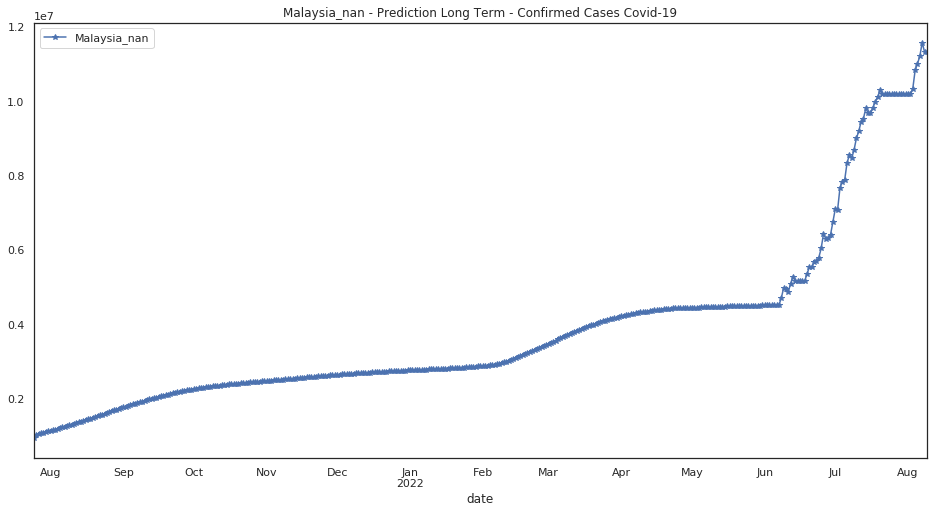

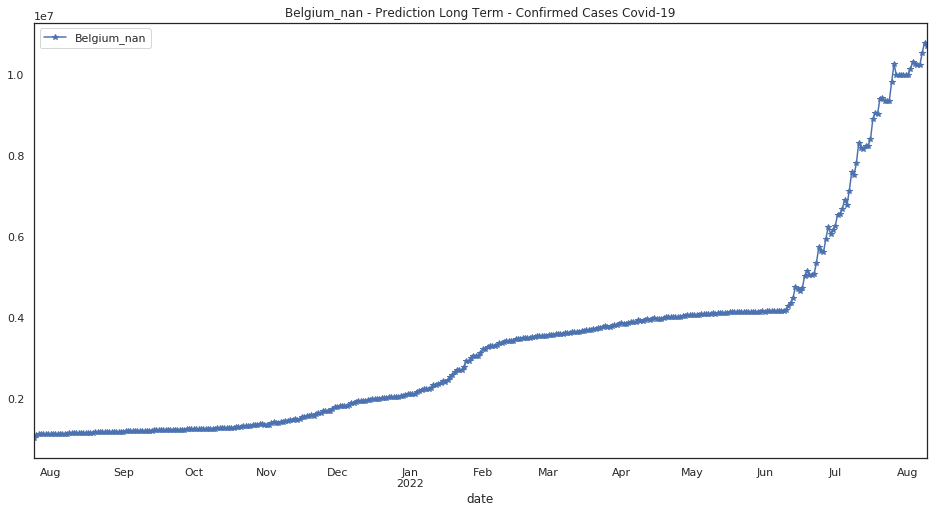

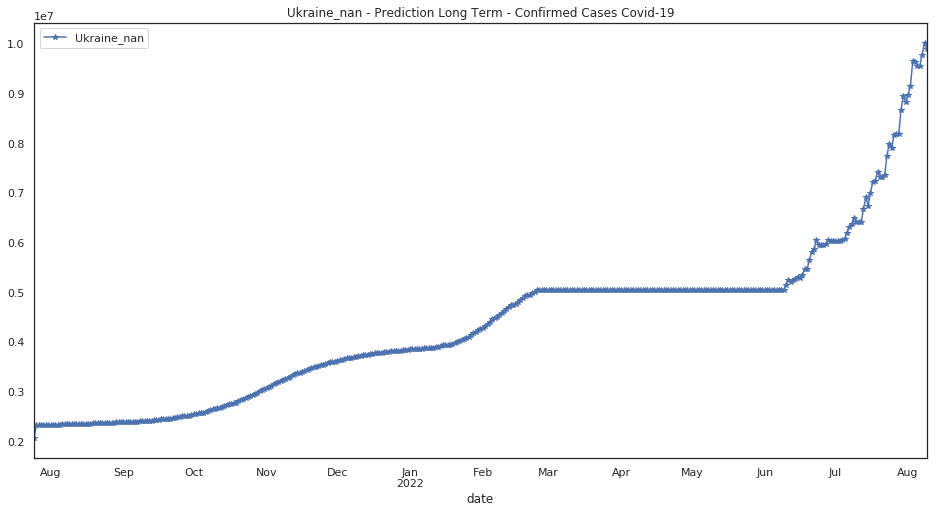

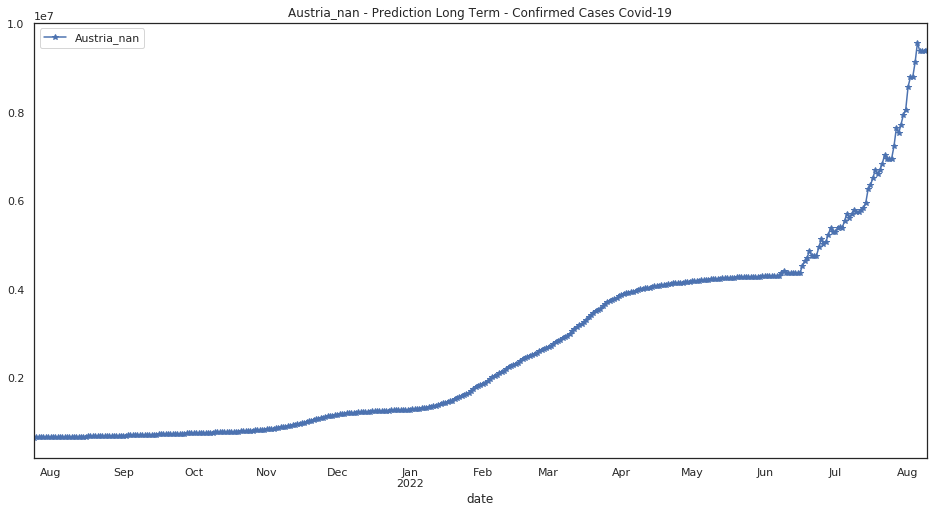

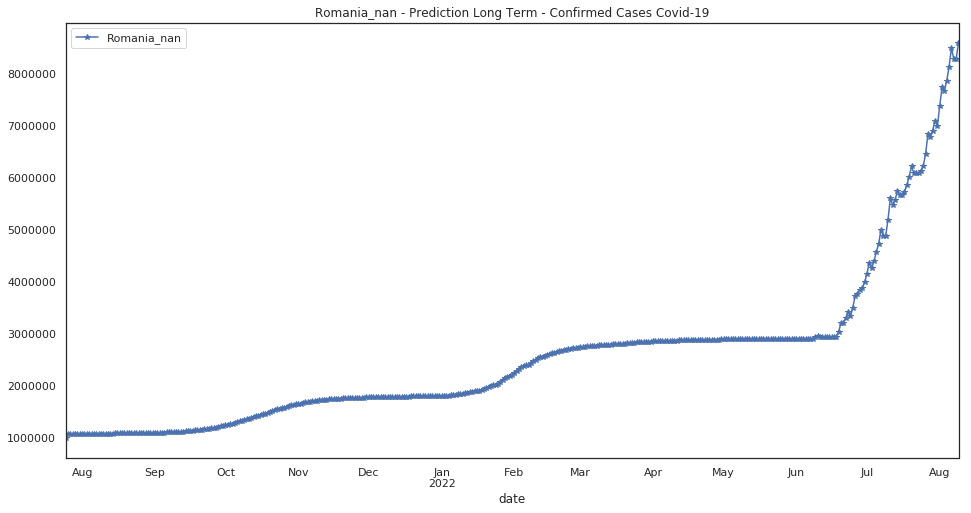

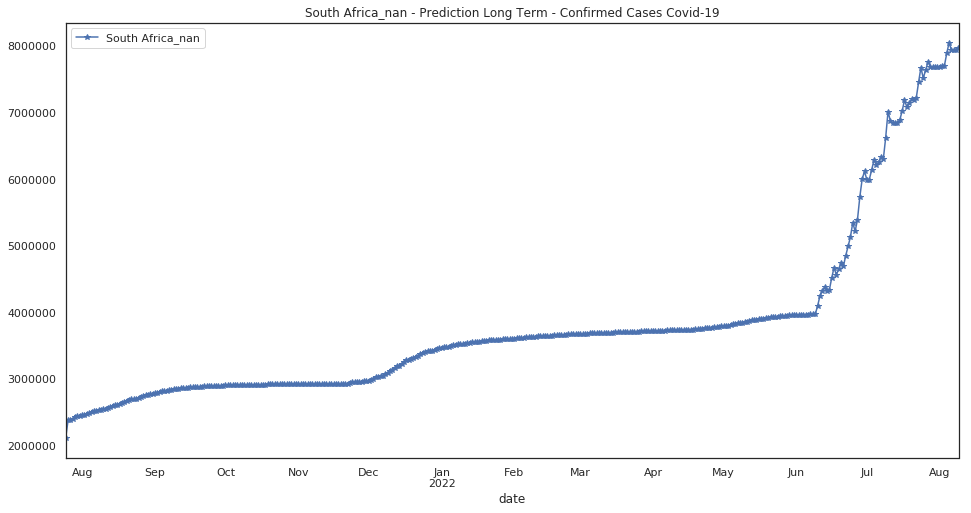

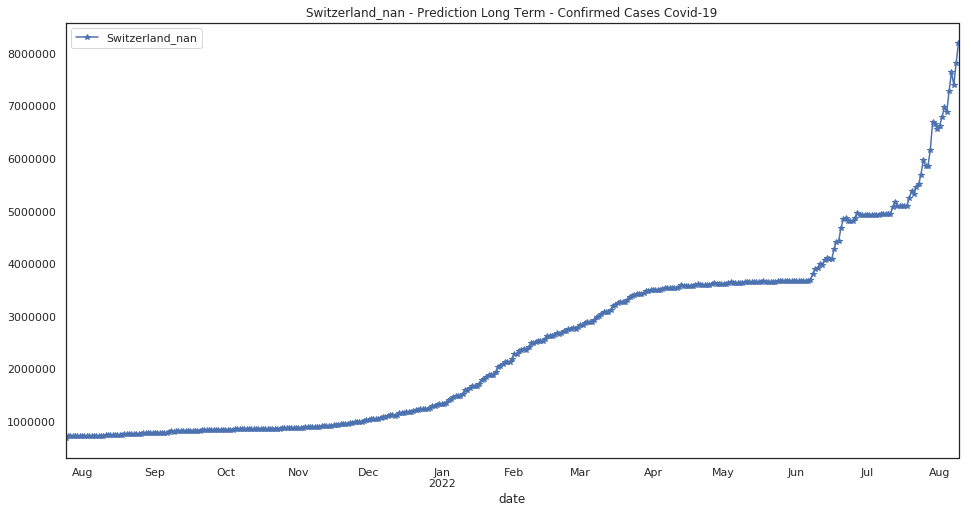

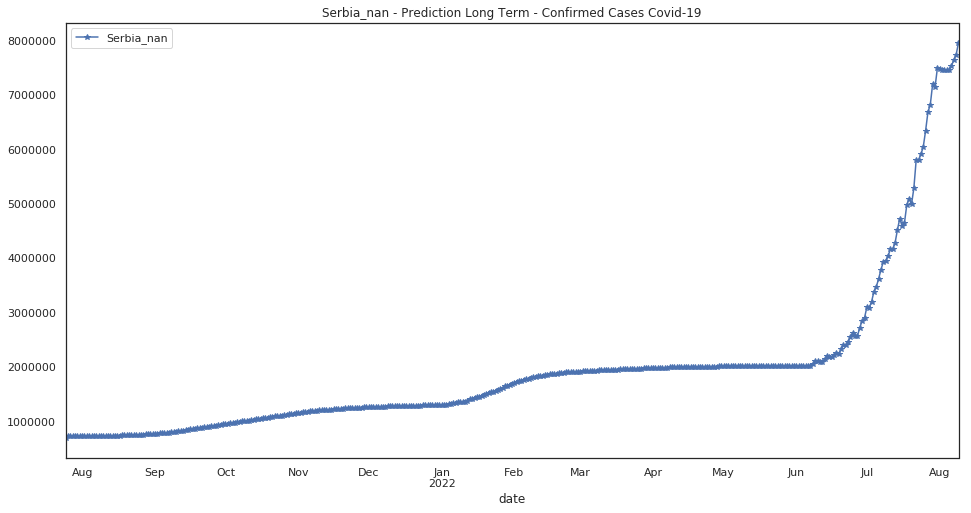

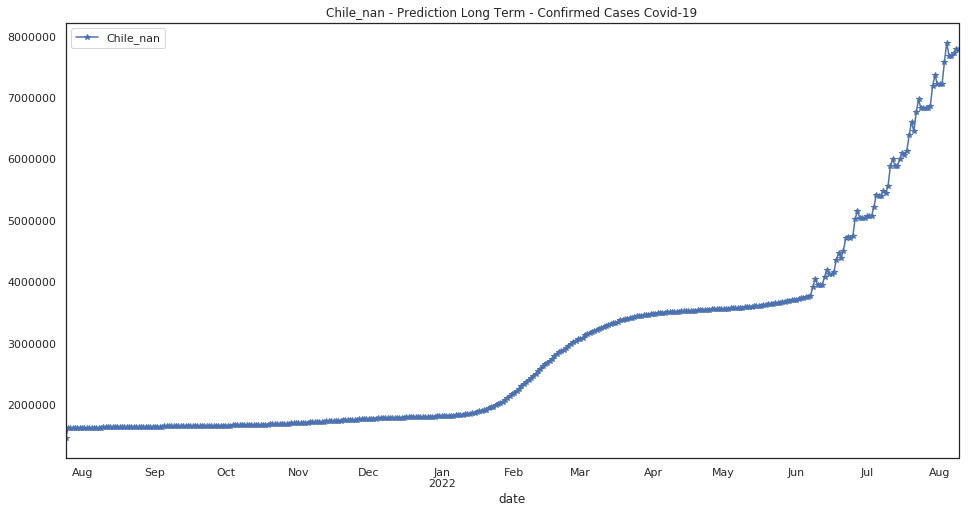

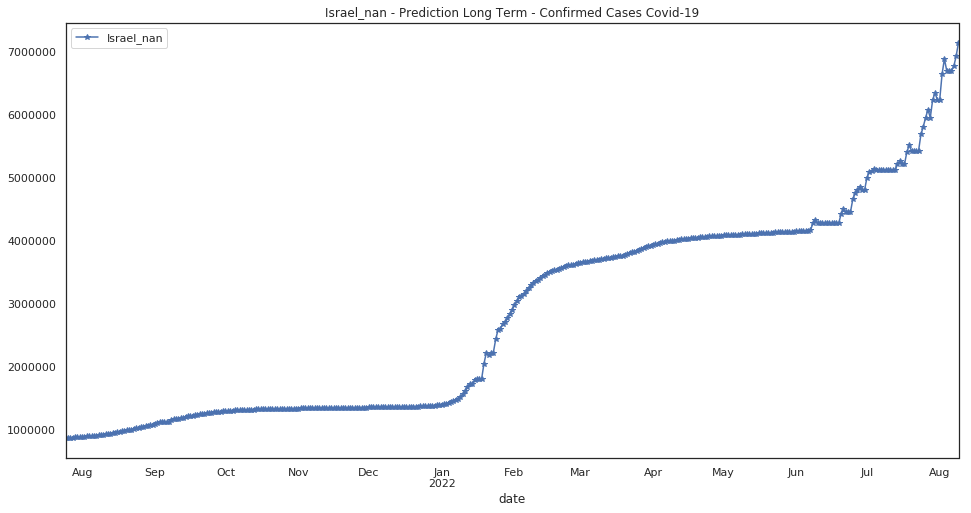

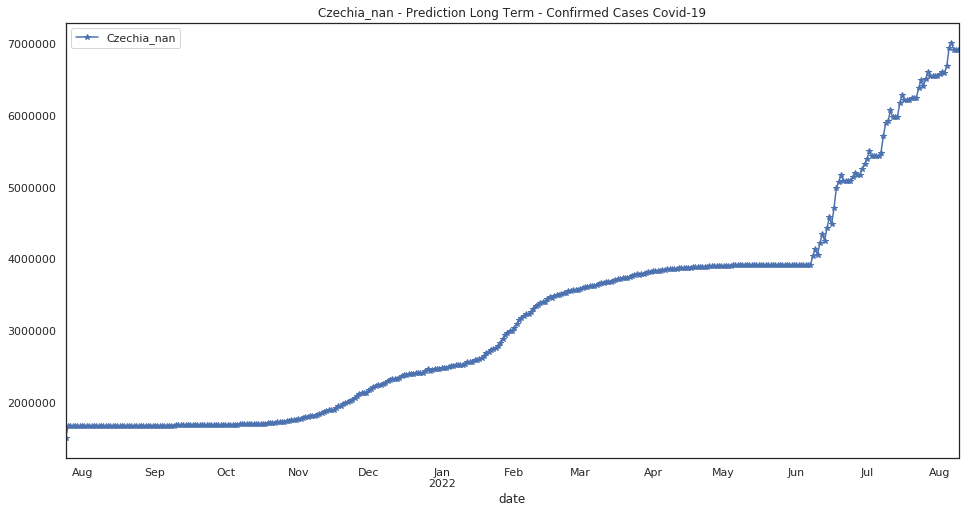

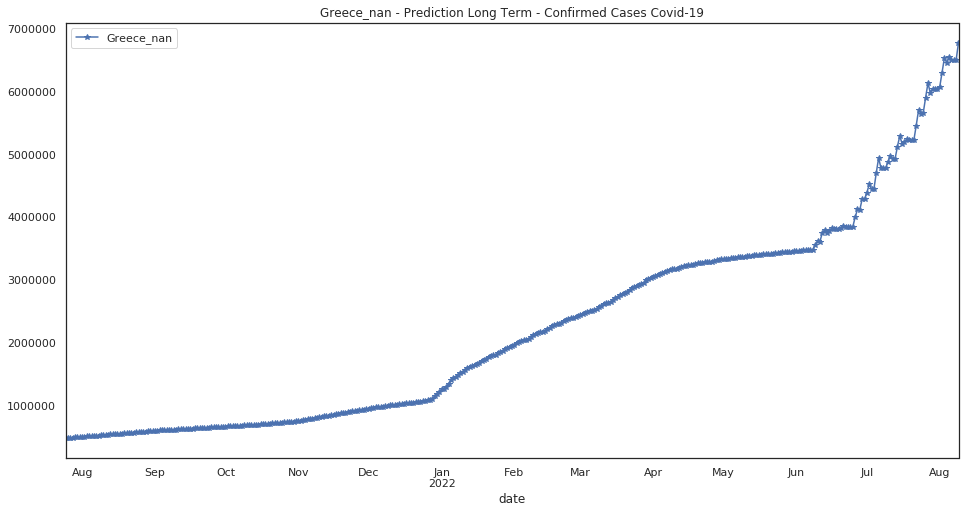

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

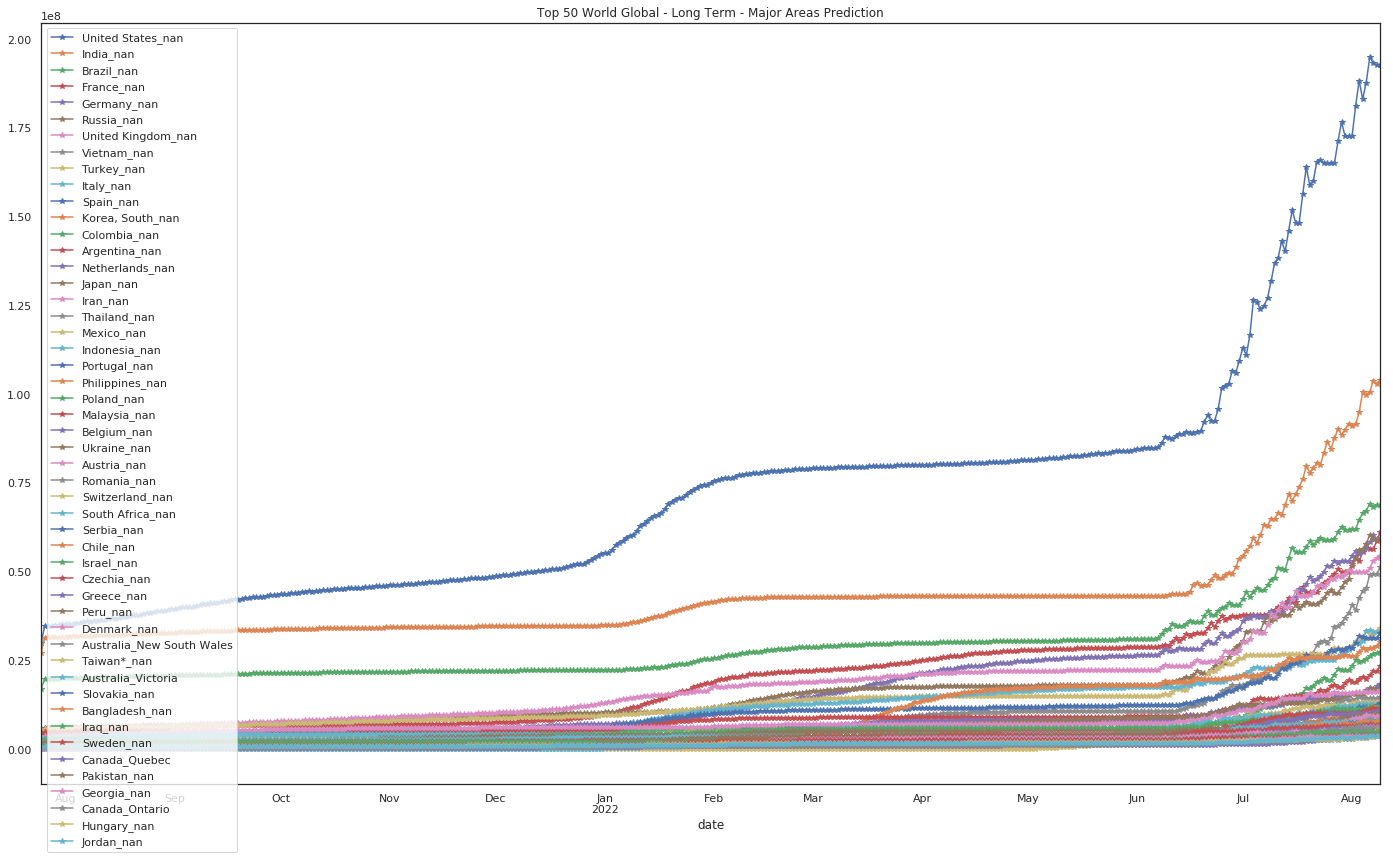

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

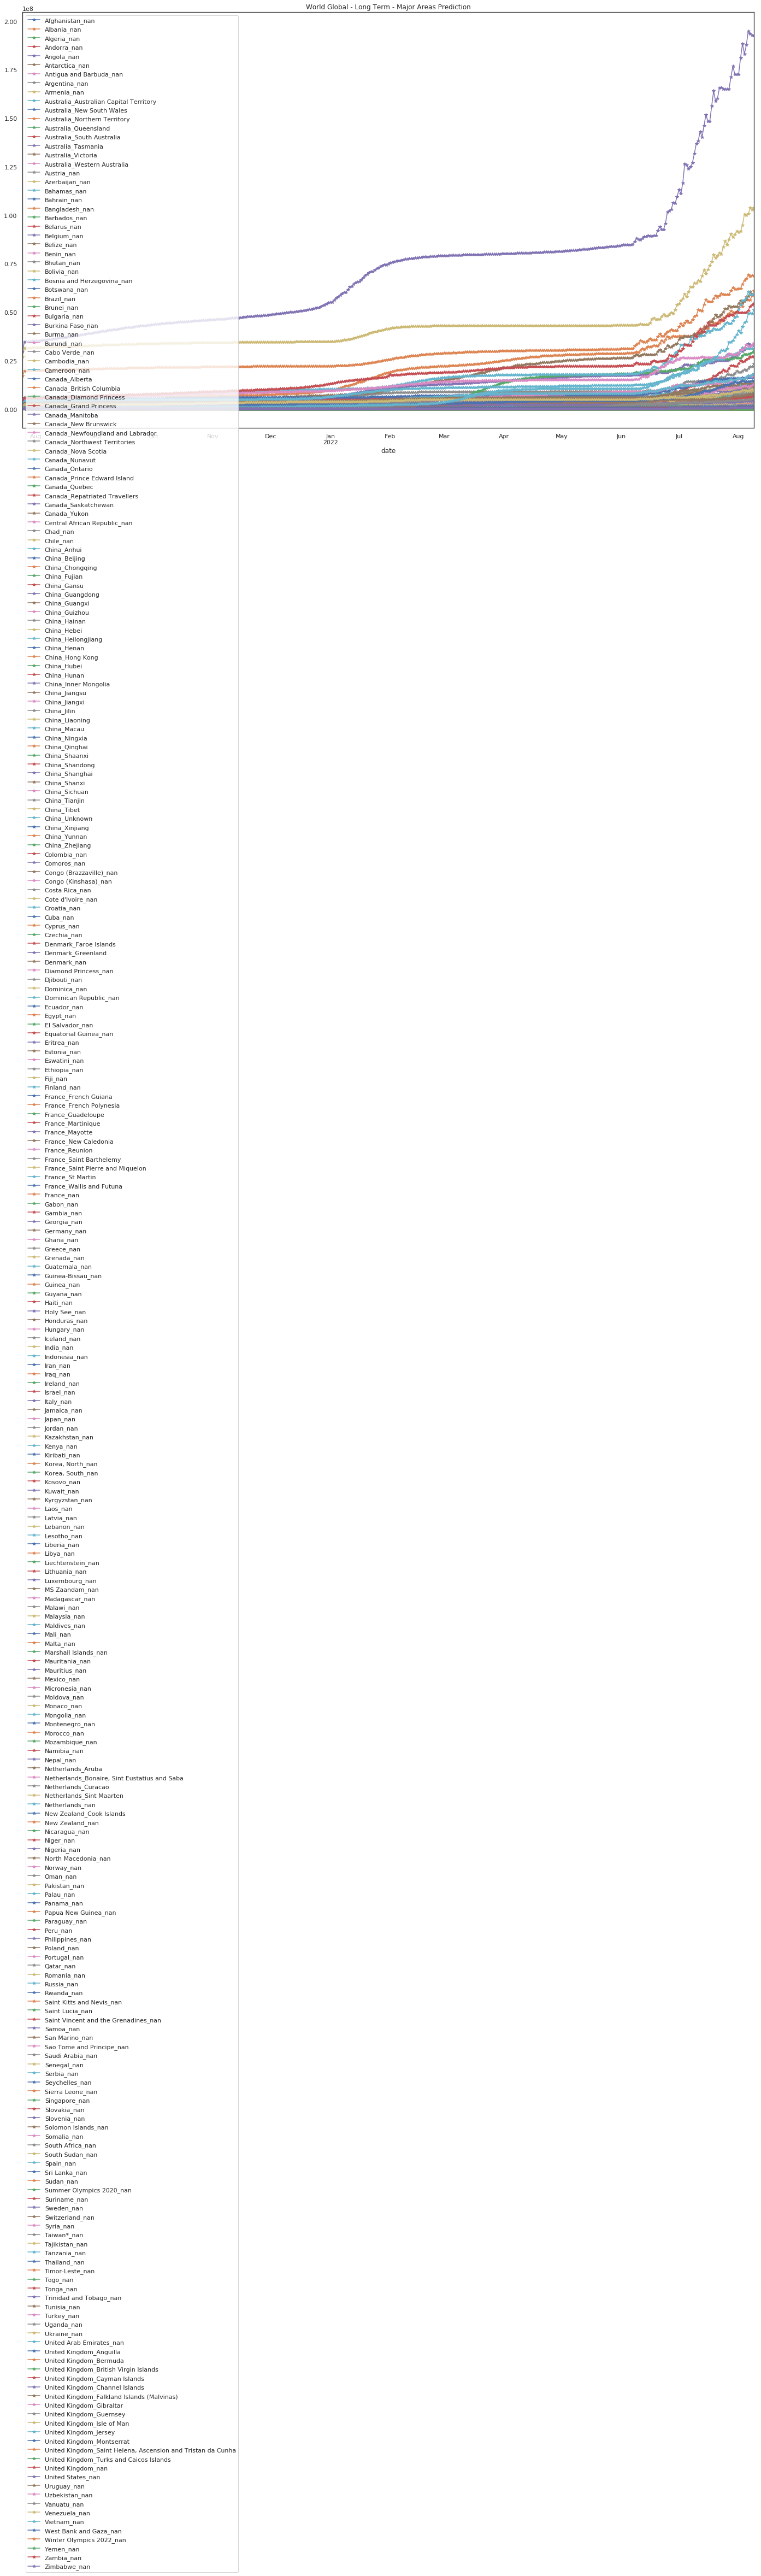

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-09-08         155011.0     154030.0     200150.0      15397.0   
2021-09-09         155116.0     155075.0     200467.0      15408.0   
2021-09-10         155231.0     156050.0     200760.0      15375.0   
2021-09-11         155265.0     156933.0     201024.0      15390.0   
2021-09-12         155261.0     157786.0     201271.0      15413.0   
2021-09-13         155349.0     158258.0     201506.0      15422.0   
2021-09-14         155449.0     159106.0     201734.0      15369.0   
2021-09-15         155549.0     160161.0     201978.0      15423.0   
2021-09-16         155635.0     161117.0     202208.0      15403.0   
2021-09-17         155752.0     162082.0     202441.0      15429.0   
2021-09-18         155776.0     162949.0     202653.0      15405.0   
2021-09-19         155760.0     163721.0     202826.0      15453.0   
2021-09-20         155843.0     164210.0     202991.0      15465.0   
2021-09-21         155977.0     164961.0     203171.0      15396.0   
2021-09-22         156038.0     165856.0     203352.0      15479.0   
2021-09-23         156075.0     166634.0     203517.0      15427.0   
2021-09-24         156219.0     167459.0     203682.0      15479.0   
2021-09-25         156255.0     168161.0     203818.0      15446.0   
2021-09-26         156234.0     168699.0     203956.0      15492.0   
2021-09-27         156330.0     169016.0     204117.0      15511.0   
2021-09-28         156375.0     169526.0     204285.0      15419.0   
2021-09-29         156403.0     170255.0     204445.0      15520.0   
2021-09-30         156451.0     170949.0     204603.0      15474.0   
2021-10-01         156472.0     171610.0     204763.0      15492.0   
2021-10-02         156478.0     172179.0     204905.0      15548.0   
2021-10-03         156475.0     172644.0     205033.0      15544.0   
2021-10-04         156557.0     172696.0     205158.0      15580.0   
2021-10-05         156604.0     173327.0     205288.0      15398.0   
2021-10-06         156659.0     174067.0     205417.0      15594.0   
2021-10-07         156717.0     174570.0     205525.0      15561.0   
...                     ...          ...          ...          ...   
2022-07-11         339992.0     339018.0     376432.0      74741.0   
2022-07-12         354844.0     345887.0     380325.0      74741.0   
2022-07-13         376103.0     347929.0     382708.0      74741.0   
2022-07-14         377738.0     358009.0     381157.0      75958.0   
2022-07-15         374334.0     358308.0     392795.0      77917.0   
2022-07-16         375726.0     357385.0     399049.0      77917.0   
2022-07-17         380752.0     357385.0     411723.0      77917.0   
2022-07-18         384351.0     357385.0     422404.0      77917.0   
2022-07-19         391224.0     357385.0     414404.0      78499.0   
2022-07-20         398123.0     367405.0     414404.0      81195.0   
2022-07-21         394179.0     373825.0     414404.0      81195.0   
2022-07-22         394179.0     369409.0     422173.0      84410.0   
2022-07-23         394244.0     385800.0     428164.0      84410.0   
2022-07-24         407775.0     395242.0     444986.0      89030.0   
2022-07-25         416292.0     388533.0     459248.0      89030.0   
2022-07-26         409934.0     394725.0     453348.0      89895.0   
2022-07-27         410281.0     405309.0     456492.0      89895.0   
2022-07-28         431365.0     412002.0     467237.0      89961.0   
2022-07-29         444195.0     412323.0     475720.0      89961.0   
2022-07-30         434617.0     411295.0     480008.0      89961.0   
2022-07-31         454617.0     435268.0     510252.0      89961.0   
2022-08-01         468453.0     450209.0     524705.0      91166.0   
2022-08-02         459223.0     440185.0     524720.0      91166.0   
2022-08-03         459223.0     456808.0     529371.0      92303.0   
2022-08-04

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
261                                        Tunisia_nan  33.886917    9.537499   
262                                         Turkey_nan  38.963700   35.243300   
263                                  United States_nan  40.000000 -100.000000   
264                                         Uganda_nan   1.373333   32.290275   
265                                        Ukraine_nan  48.379400   31.165600   
266                           United Arab Emirates_nan  23.424076   53.847818   
267                            United Kingdom_Anguilla  18.220600  -63.068600   
268                             United Kingdom_Bermuda  32.307800  -64.750500   
269              United Kingdom_British Virgin Islands  18.420700  -64.640000   
270                      United Kingdom_Cayman Islands  19.313300  -81.254600   
271                     United Kingdom_Channel Islands  49.372300   -2.364400   
272         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
273                           United Kingdom_Gibraltar  36.140800   -5.353600   
274                            United Kingdom_Guernsey  49.448196   -2.589490   
275                         United Kingdom_Isle of Man  54.236100   -4.548100   
276                              United Kingdom_Jersey  49.213800   -2.135800   
277                          United Kingdom_Montserrat  16.742498  -62.187366   
278  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      15         Australia_Victoria -37.813600  144.963100   
3      17                Austria_nan  47.516200   14.550100   
4      21             Bangladesh_nan  23.685000   90.356300   
5      24                Belgium_nan  50.833300    4.469936   
6      31                 Brazil_nan -14.235000  -51.925300   
7      52             Canada_Ontario  51.253800  -85.323200   
8      54              Canada_Quebec  52.939900  -73.549100   
9      60                  Chile_nan -35.675100  -71.543000   
10     95               Colombia_nan   4.570900  -74.297300   
11    104                Czechia_nan  49.817500   15.473000   
12    107                Denmark_nan  56.263900    9.501800   
13    133                 France_nan  46.227600    2.213700   
14    136                Georgia_nan  42.315400   43.356900   
15    137                Georgia_nan  42.315400   43.356900   
16    138                Germany_nan  51.165691   10.451526   
17    140                 Greece_nan  39.074200   21.824300   
18    150                Hungary_nan  47.162500   19.503300   
19    152                  India_nan  20.593684   78.962880   
20    153              Indonesia_nan  -0.789300  113.921300   
21    154                   Iran_nan  32.427908   53.688046   
22    155                   Iraq_nan  33.223191   43.679291   
23    157                 Israel_nan  31.046051   34.851612   
24    158                 Israel_nan  31.046051   34.851612   
25    159                  Italy_nan  41.871940   12.567380   
26    161                  Japan_nan  36.204824  138.252924   
27    162                 Jordan_nan  31.240000   36.510000   
28    167           Korea, South_nan  35.907757  127.766922   
29    184               Malaysia_nan   4.210484  101.975766   
30    191                 Mexico_nan  23.634500 -102.552800   
31    205            Netherlands_nan  52.132600    5.291300   
32    214               Pakistan_nan  30.375300   69.345100   
33    219                   Peru_nan  -9.190000  -75.015200   
34    220            Philippines_nan  12.879721  121.774017   
35    221                 Poland_nan  51.919400   19.145100   
36    222               Portugal_nan  39.399900   -8.224500   
37    224                Romania_nan  45.943200   24.966800   
38    225                 Russia_nan  61.524010  105.318756   
39    235                 Serbia_nan  44.016500   21.005900   
40    239               Slovakia_nan  48.669000   19.699000   
41    243           South Africa_nan -30.559500   22.937500   
42    245                  Spain_nan  40.463667   -3.749220   
43    250                 Sweden_nan  60.128161   18.643501   
44    251            Switzerland_nan  46.818200    8.227500   
45    253                Taiwan*_nan  23.700000  121.000000   
46    256               Thailand_nan  15.870032  100.992541   
47    262                 Turkey_nan  38.963700   35.243300   
48    263          United States_nan  40.000000 -100.000000   
49    265                Ukraine_nan  48.379400   31.165600   
50    280         United Kingdom_nan  55.378100   -3.436000   
51    285                Vietnam_nan  14.058324  108.277199   

    2021-07-25 00:00:00  2021-07-26 00:00:00  2021-07-27 00:00:00  \
0             4235575.0            4846615.0            4875177.0   
1               79955.0              80105.0               8118.0   
2               91095.0              91104.0              20924.0   
3              632796.0             651653.0             651978.0   
4             1073362.0            1164635.0            1196350.0   
5             1029416.0            1113465.0            1117697.0   
6            16986406.0           19693277.0           19756552.0   
7              548202.0             553155.0             553286.0   
8              396702.0             396766.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred, parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()